# VIIRS Analysis
This notebook provides scripts that generate analyses and figures using the VIIRS (Visible Infrared Imaging Radiometer Suite) datasets for the paper "Illuminating Dark Fishing Fleets in North Korea" published in Science Advances on July 22, 2020. The datasets used in the notebook are publicly available under `global-fishing-watch.paper_dark_fishing_fleets_in_north_korea` BigQuery bucket.

Last updated: 28 June 2020

Developed by Global Fishing Watch Inc.

In [1]:
#
# Import all necessary packages
#
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

import calendar
import datetime
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib import colors,colorbar
import matplotlib.pylab as pl
import matplotlib
%matplotlib inline
from matplotlib.lines import Line2D

In [2]:
#
# Pre-defined boundaries (See Supplementary materials for detail)
#
_eez_prk_wo_mz = '../1-boundary/eez_prk_wo_mz/eez_prk_wo_mz'
_eez_prk_mz = '../1-boundary/eez_prk_mz/eez_prk_mz'
_eez_prk_no_shoreline = '../1-boundary/eez_prk/eez_prk_no_shoreline'
_study_area = '../1-boundary/study_area/study_area'
_eez_rus_south_wo_12nm = '../1-boundary/eez_rus_south_wo_12nm/eez_rus_south_wo_12nm'
_eez_rus_north_wo_12nm = '../1-boundary/eez_rus_north_wo_12nm/eez_rus_north_wo_12nm'
_eez_rus_near_prk_wo_12nm = '../1-boundary/eez_rus_near_prk_wo_12nm/eez_rus_near_prk_wo_12nm'
_eez_rus_12nm = '../1-boundary/eez_rus_12nm/eez_rus_12nm'

# Fig.S18. Sensitivity of the estimated number of vessels and vessel days to radiance thresholds for the Japanese and South Korean fleets operating in the Russian EEZ, August and September 2017.

According to South Korean and Japanese authorities, in the 30 days from August 15 2017 to September 13, 2017, South Korean and Japanese vessels were active for 1,367 days. The daily number of vessels active ranged from 44 to 47 (see figure S19).  

```
date          vessels present
----------  -----------------
2017-08-15                 44
2017-08-16                 45
2017-08-17                 45
2017-08-18                 45
2017-08-19                 45
2017-08-20                 44
2017-08-21                 45
2017-08-22                 45
2017-08-23                 46
2017-08-24                 46
2017-08-25                 46
2017-08-26                 46
2017-08-27                 46
2017-08-28                 46
2017-08-29                 46
2017-08-30                 46
2017-08-31                 46
2017-09-01                 46
2017-09-02                 46
2017-09-03                 47
2017-09-04                 46
2017-09-05                 45
2017-09-06                 45
2017-09-07                 45
2017-09-08                 47
2017-09-09                 47
2017-09-10                 46
2017-09-11                 45
2017-09-12                 45
2017-09-13                 45
```


In [3]:
q = """
SELECT *
FROM `paper_dark_fishing_fleets_in_north_korea.viirs_rus_eez_north_2017`
"""
rus_eez_north = pd.read_gbq(q, project_id='global-fishing-watch', dialect='standard')

In [4]:
#
# Download the vessel operation log of the S.Korean fleet in Russian waters
#
q = """
# StandardSQL
# "number" is the vessel ID number
SELECT *
FROM `paper_dark_fishing_fleets_in_north_korea.kor_entry_log_in_rus_2017` 
ORDER BY number, date_operation
"""  
kor = pd.read_gbq(q, project_id='global-fishing-watch', dialect='standard')

#
# Calculate the remaining vessels in operation based on the operation 
# record of the fleet above (plus 1 Japanese vessel in operation)
#

#
# Time setting
startdate = datetime.datetime(2017,8,15)
enddate = datetime.datetime(2017,9,13)
num_vessels = []

#
# Convert the date of operation (in String) into datetime type
kor['date_operation'] = kor['date_operation']\
                            .apply(lambda x: pd.to_datetime(x).date())

#
# on/off signal, 0 represents the "on" event -- a vessel is 
# on fishing operation in Russian waters, and 1 represents the "off" event
# -- a vessel heads back from Russian waters to its port to unload its catch
kor['onoff'] = kor['onoff'].apply(int)

#
# Loop through days within the period of interest (30 days) and 
# calculate how many vessels are actually within the Russian waters
for current_date in pd.date_range(startdate, enddate):
    current_date = current_date.date()
    count=0
    for index, group in kor.groupby('number'):
        #
        # Flag to indicate if the vessel is IN Russian waters
        # at the current date
        flag=False
        
        for idx, row in group.sort_values('date_operation').iterrows():
            #
            # Flag if the vessel is in Russian waters at the current date
            if row['onoff'] == 0 and row['date_operation'] <= current_date:
                flag = True
            #
            # Count when the off date is later than current date
            # (it means the vessel has not left the Russian waters)
            elif row['onoff'] == 1 and row['date_operation'] >= current_date and flag:
                count += 1
                break
            else:
                flag = False
                
    #
    # List of counts of the vessels in operation by days
    num_vessels.append(count)
    
#
# Add one Japanese vessel known to be operating in this period
# except 20-22 August 2017 where it is known that they came back to 
# Japanese port
num_vessels = [n if (i >= 5)&(i <= 7) else n + 1 for i, n in enumerate(num_vessels)]

In [5]:
# sum the vessels present in the above table:
actual_vessel_days_sjk = np.array(num_vessels).sum()

In [6]:
# get the number of detections that are likely south korean and japanese vessels
# Lat_DNB: Latitude of the detection
# Lon_DNB: Longitude of the detection
# Date_Mscan: timestamp of detection
# Rad_DNB: Radiance level of detection
# SATZ_GDNBO: Satellite angle at time of detection
#
q = '''SELECT
  Lat_DNB AS lat,
  Lon_DNB AS lon,
  date(Date_Mscan) AS date,
  Rad_DNB as rad,
  SATZ_GDNBO
FROM
`global-fishing-watch.paper_dark_fishing_fleets_in_north_korea.viirs_rus_eez_north_2017`
where date(Date_Mscan) between "2017-08-15" and "2017-09-13"

'''
df_skorea_japan_lights = pd.read_gbq(q, project_id='global-fishing-watch', 
                                     dialect='standard')

In [7]:
# Get the maximuim number of vessels for different cutoffs

startdate = datetime.datetime(2017, 8, 15)
enddate = datetime.datetime(2017, 9, 13)
the_dates = pd.date_range(startdate, enddate)

radiances = np.arange(0, 1000, 2) 
max_vessels_above_threshold = np.zeros(len(radiances))

df = df_skorea_japan_lights
for i, radiance in enumerate(radiances):
    max_cnt = 0
    dets_above_radiance = df[df.rad > radiance]
    for date in the_dates:
        max_cnt = max(max_cnt, (dets_above_radiance.date == date).sum())
    max_vessels_above_threshold[i] = max_cnt
    
# Our team of data scientists found that the above method was 
# embarassingly slow, so they wrote a much, much faster version of
# the code above, but it is much less readible.
# See the bottom of this notebook to find out more. 

In [8]:
# calculate the maximum number of vessels active in the
# first 15 day period, at different radiance thresholds.

vessels_days_first_15_days = []

for radiance in radiances:
    max_cnt=0
    df = df_skorea_japan_lights
    d = df[df.rad > radiance]
    for the_date in the_dates[:15]:
        n = (d.date == the_date).sum()
        if n > max_cnt:
            max_cnt = n
    vessels_days_first_15_days.append(max_cnt)

# calculate the maximum number of vessels active in 
# the second 15 day period, at different radiance thresholds
vessels_days_second_15_days = []
for radiance in radiances:
    max_cnt = 0
    df = df_skorea_japan_lights
    d = df[df.rad > radiance]
    for the_date in the_dates[15:]:
        n = (d.date == the_date).sum()
        if n > max_cnt:
            max_cnt = n
    vessels_days_second_15_days.append(max_cnt)

# Take the maximum number for each 15 days and multiply by 15 
# to get the estimated total fishing days for a given threshold.
# Then add the two arrays to get the total estimate fishing days
# one would calculate by taking the maximum from each 15 days
vessels_days_above_threshold = np.add(np.array(vessels_days_first_15_days)*15,
                               np.array(vessels_days_second_15_days)*15)

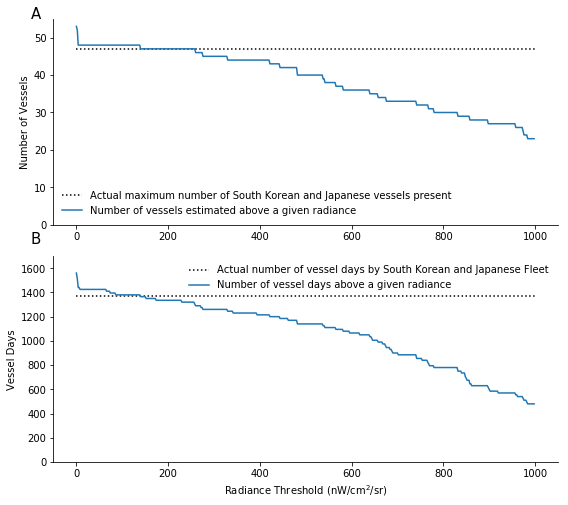

In [9]:
fig = plt.figure(figsize=(8,7), facecolor='white')
ax1 = plt.subplot(2, 1, 1)

ax1.plot([0,1000],[47,47],':', 
         label = 'Actual maximum number of South Korean and Japanese vessels present',
         color='black')
ax1.plot(radiances,
         max_vessels_above_threshold,
         label='Number of vessels estimated above a given radiance')
ax1.set_facecolor('white')
plt.legend(frameon=False)
plt.ylabel("Number of Vessels") 
plt.ylim(0,55)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
plt.text(-100,55,"A",fontsize=15)



ax2 = plt.subplot(2, 1, 2)
ax2.plot([0,1000],[actual_vessel_days_sjk,actual_vessel_days_sjk], ':', 
         label = 'Actual number of vessel days by South Korean and Japanese Fleet', 
         color='black')
ax2.plot(radiances,
         vessels_days_above_threshold,
         label='Number of vessel days above a given radiance')
ax2.set_facecolor('white')
plt.legend(frameon=False)
plt.xlabel("Radiance Threshold (nW/cm$^2$/sr)")
plt.ylabel("Vessel Days") 
plt.ylim(0,1700)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
plt.text(-100,1800,"B",fontsize=15)

plt.tight_layout()
plt.show()

## Fig. S19 - Daily light detection in the northern part of the Russian EEZ (S.Korean and Japanese squid jiggers operating in Russian waters)

In [10]:
#
# Plot the daily VIIRS detection counts of South Korean (48 of them)
# plus 1 Japanese squid vessels in operation in Russian waters 
# from mid-August to mid-September 2017
#
from matplotlib import colors, colorbar

def viirs_daily_sk(data, date1, date2, num_vessels, title=""):
    """
    data: DataFrame, VIIRS detection data set 
    date1: String, start date in the format of YYYYMMDD
    date2: String, end date in the format of YYYYMMDD
    num_vessels: List of integers, daily vessel counts by log records
    title: String, title of the figure
    """
    
    #
    # Parameter setting
    df = data.copy()
    df['date'] = df['Date_Mscan'].apply(lambda x: x.date())
    startdate = datetime.datetime.strptime(date1, "%Y%m%d")
    enddate = datetime.datetime.strptime(date2, "%Y%m%d")
    nums = []
    
    #
    # Loop through daily detections to filter VIIRS detection 
    # for the period of interest and categorize detections by intensity
    for current_date in pd.date_range(startdate, enddate):
        current_date = current_date.date()
        df_day = df[df['date'] == current_date]
        
        #
        # Categorize detections by high, mid, and low levels
        if len(df_day) > 0:
            nums.append(df_day[df_day['Rad_DNB'] > 140]['Rad_DNB']\
                        .sort_values(ascending=False).values)
        else:
            nums.append([])
           
    #
    # Figure setting
    fig = plt.figure(figsize=(16,6), facecolor='white', dpi=300)
    ax = fig.add_subplot(111)
    cmap_viirs = ("#FDC24B", "#FA792F", "#AD001D")
    c = cmap_viirs
    color_ramp = [[c[0],0,0],
                  [c[1],50,50],
                  [c[2],100,100]]

    tm = 100.0 # This is just to scale the following. this makes the colormap
    cdict = { 
        'red':tuple(   (color[2]/tm, 
                        int(color[0][1:3],16)/256.0, 
                        int(color[0][1:3],16)/256.0) for color in color_ramp ),
        'green':tuple( (color[2]/tm, 
                        int(color[0][3:5],16)/256.0, 
                        int(color[0][3:5],16)/256.0) for color in color_ramp ),
        'blue':tuple(  (color[2]/tm, 
                        int(color[0][5:7],16)/256.0, 
                        int(color[0][5:7],16)/256.0) for color in color_ramp )
    }

    cmap = colors.LinearSegmentedColormap('my_colormap', cdict, 256)
    cmap.set_bad(alpha = 0.0)

    #
    # Plot stacked bar chart
    for d in range(max([len(daily_d) for daily_d in nums])):
        ax.bar(range(len(nums)), [1 if len(n) > d else 0 for n in nums],
               bottom=[d for n in nums],
               color=cmap([(n[d] - 140) / (500 - 140.0) if len(n) > d else 0 for n in nums]))

    #
    # Plot the vessel count by log records
    ax.plot(num_vessels, color='#636363', 
            marker='_', markersize=30, linestyle="None")
    ax.plot([], [], linewidth=1.2, linestyle='-', color='#636363', 
            label='Number of S.Korean and Japanese present')

    #
    # Axes, labels
    ax.set_facecolor((1,1,1))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.grid(lw=0.2, axis='y')
    ax.tick_params(axis=u'both', which=u'both',length=0)
    
    plt.ylabel('Number of Detections', fontsize=18)
    plt.ylim(0,61)
    plt.xticks(range(len(nums)), 
               [datetime.datetime.strftime(
                   startdate + datetime.timedelta(days=d), "%m/%d")
                for d in range((enddate-startdate).days)], 
               rotation=70,  fontsize=12) 
    plt.xlabel('Month/Day in 2017', fontsize=18) 
    
    ax.xaxis.set_label_coords(.5, -0.15)
    
    #
    # Add colorbar
    norm = colors.Normalize(vmin = 140, vmax = 500)
    ax1 = fig.add_axes([0.99, 0.2, 0.01, 0.6])
    cb = colorbar.ColorbarBase(ax1, norm = norm, cmap = cmap) # plt.get_cmap('Reds'))
    cb.set_ticks([140, 200, 250, 300, 350, 400, 450, 500])
    cb.set_ticklabels(['140', '200', '250', '300', '350', '400', '450', '>500'])
    cb.set_label('Radiance in nW/cm2/sr', labelpad=-55, y=0.50, color = "#000000")
    cb.ax.invert_yaxis() 
    
    fig.tight_layout()
    plt.show()

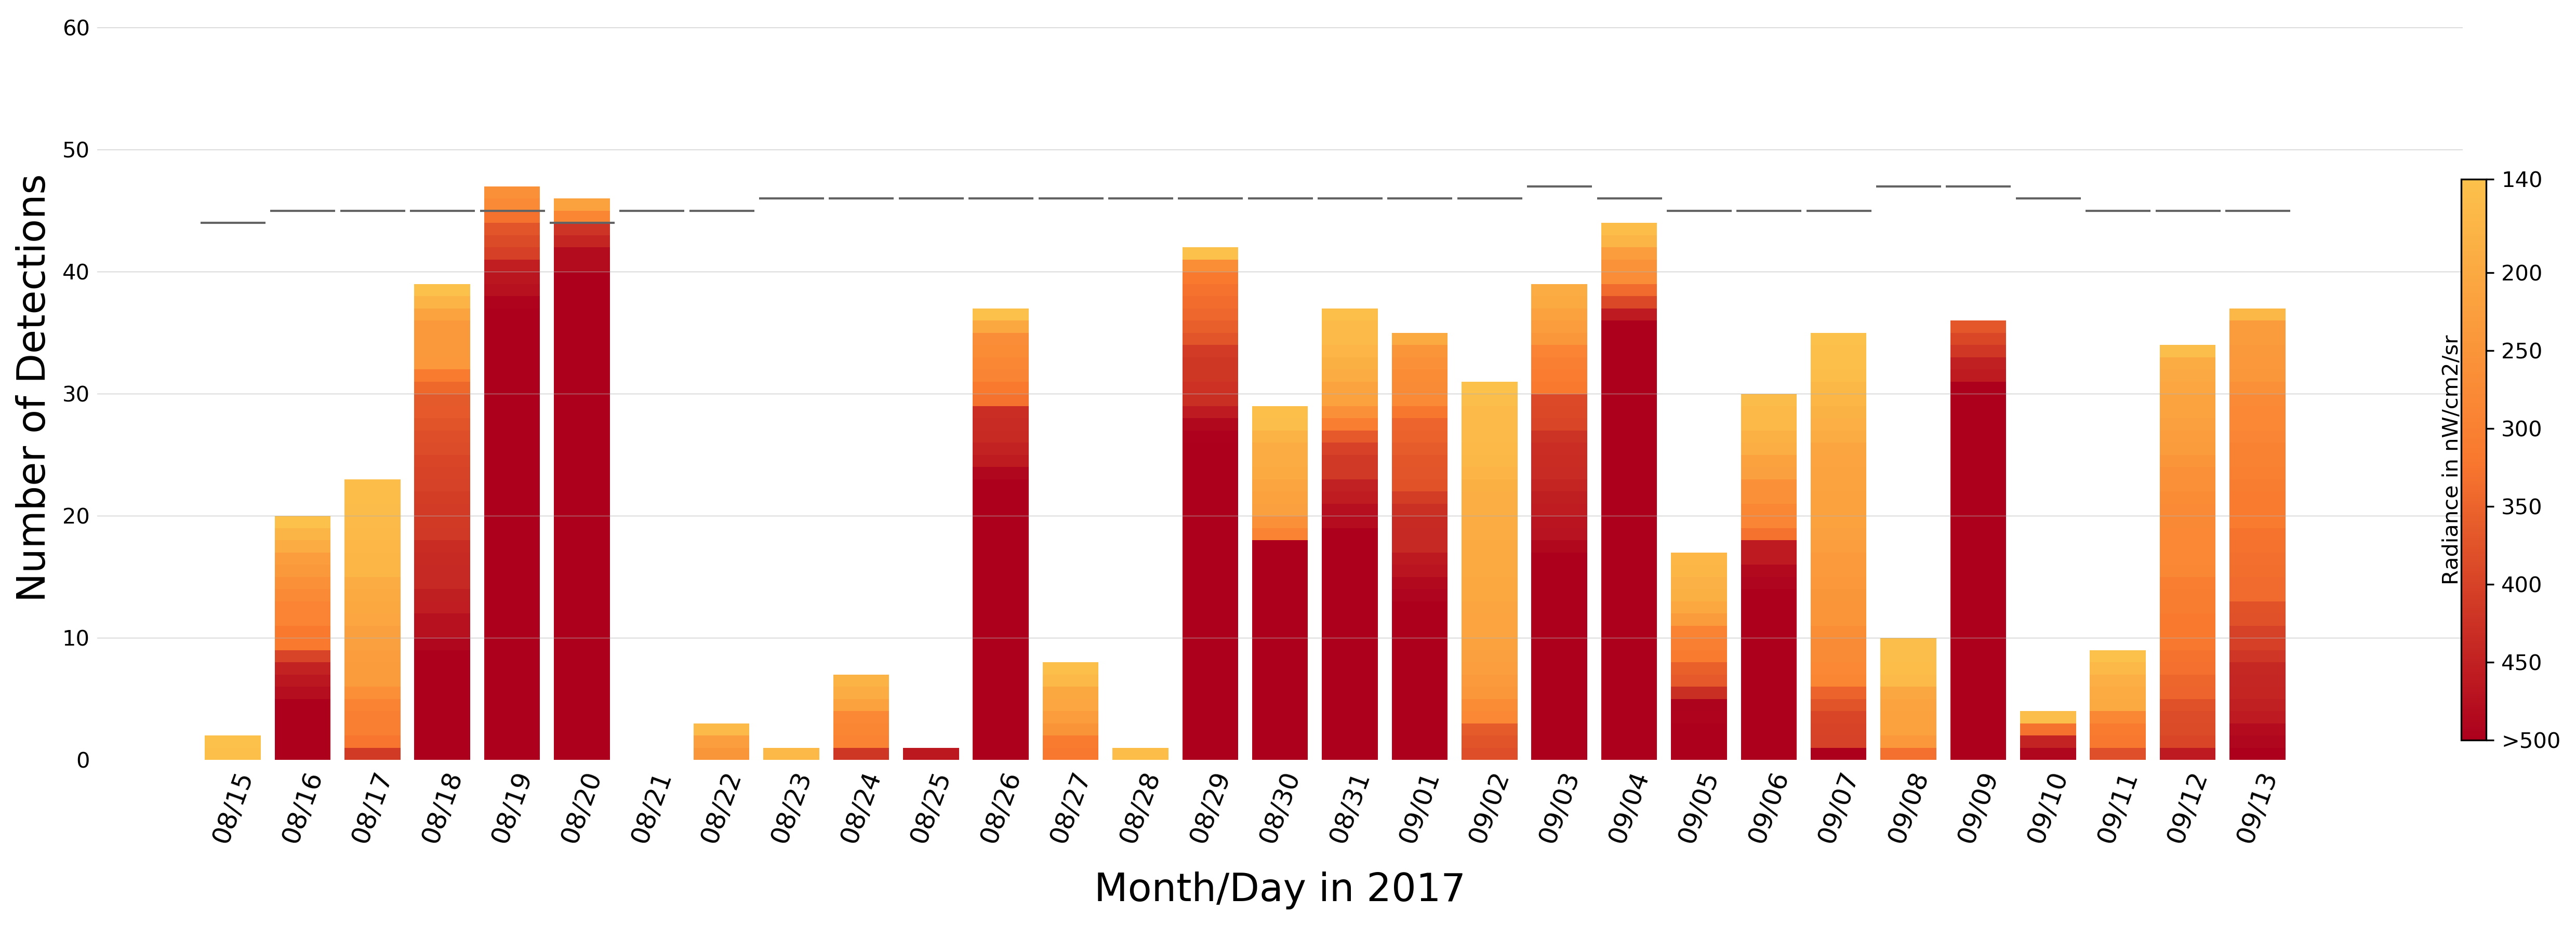

In [11]:
viirs_daily_sk(rus_eez_north, '20170815', '20170914', num_vessels)

# Fig. S20 - Fraction of VIIRS vessel detections below a given threshold

In [12]:
# Russian_territorial waters
def get_distribution(table):
    q = ''' WITH
      top_date AS (
      SELECT
        date,
        day_period
      FROM (
        SELECT
          ROW_NUMBER() OVER 
            (PARTITION BY day_period,month,year ORDER BY vessels DESC, rand() DESC) 
            AS row_number,
          date,
          day_period,
          vessels
        FROM (
          SELECT
            CAST(FLOOR(EXTRACT(day
                FROM
                  Date_Mscan)/15.6) AS int64) AS day_period,
            DATE(Date_Mscan) date,
            extract(month from Date_Mscan) month,
            extract(year from Date_Mscan) year,
            SUM(Rad_DNB) total_radiance,
            COUNT(*) vessels
          FROM
            `{table}`
          where SATZ_GDNBO < 60
          GROUP BY
            date,
            day_period,
            year,
            month
          ORDER BY
            date ) )
      WHERE
        row_number = 1)
      #
      #
      #
    SELECT
      Lat_DNB AS lat,
      Lon_DNB AS lon,
      DATE(Date_Mscan) AS date,
      Rad_DNB AS rad,
      SATZ_GDNBO
    FROM
      `{table}`
    WHERE
      SATZ_GDNBO < 60
      and DATE(Date_Mscan) IN (
      SELECT
        date
      FROM
        top_date)
      '''.format(table=table)
    df = pd.read_gbq(q, project_id='global-fishing-watch', dialect='standard')
    return df

In [13]:
df_russia_territorial = \
 get_distribution("global-fishing-watch.paper_dark_fishing_fleets_in_north_korea.viirs_rus_eez_12nm_2017")

df_russia_eez_no12nm = \
 get_distribution("global-fishing-watch.paper_dark_fishing_fleets_in_north_korea.viirs_rus_eez_wo_12nm_2017")

df_prk_mz = \
 get_distribution("global-fishing-watch.paper_dark_fishing_fleets_in_north_korea.viirs_prk_eez_mz_2017")

df_study_area_2017 = \
 get_distribution("global-fishing-watch.paper_dark_fishing_fleets_in_north_korea.viirs_study_area_2017")

df_study_area_2018 = \
 get_distribution("global-fishing-watch.paper_dark_fishing_fleets_in_north_korea.viirs_study_area_2018")

df_study_area = df_study_area_2017.append(df_study_area_2018)

In [14]:
def create_distribution(df):
    radiances = np.linspace(0,2500,2501)
    y = []
    for radiance in radiances:
        y.append(float(len(df[df.rad>radiance])))
    return np.array(y)

prk_m = create_distribution(df_prk_mz)
rus_t = create_distribution(df_russia_territorial)
rus_e = create_distribution(df_russia_eez_no12nm)
stu = create_distribution(df_study_area)
radiances = np.linspace(0, 2500, 2501)

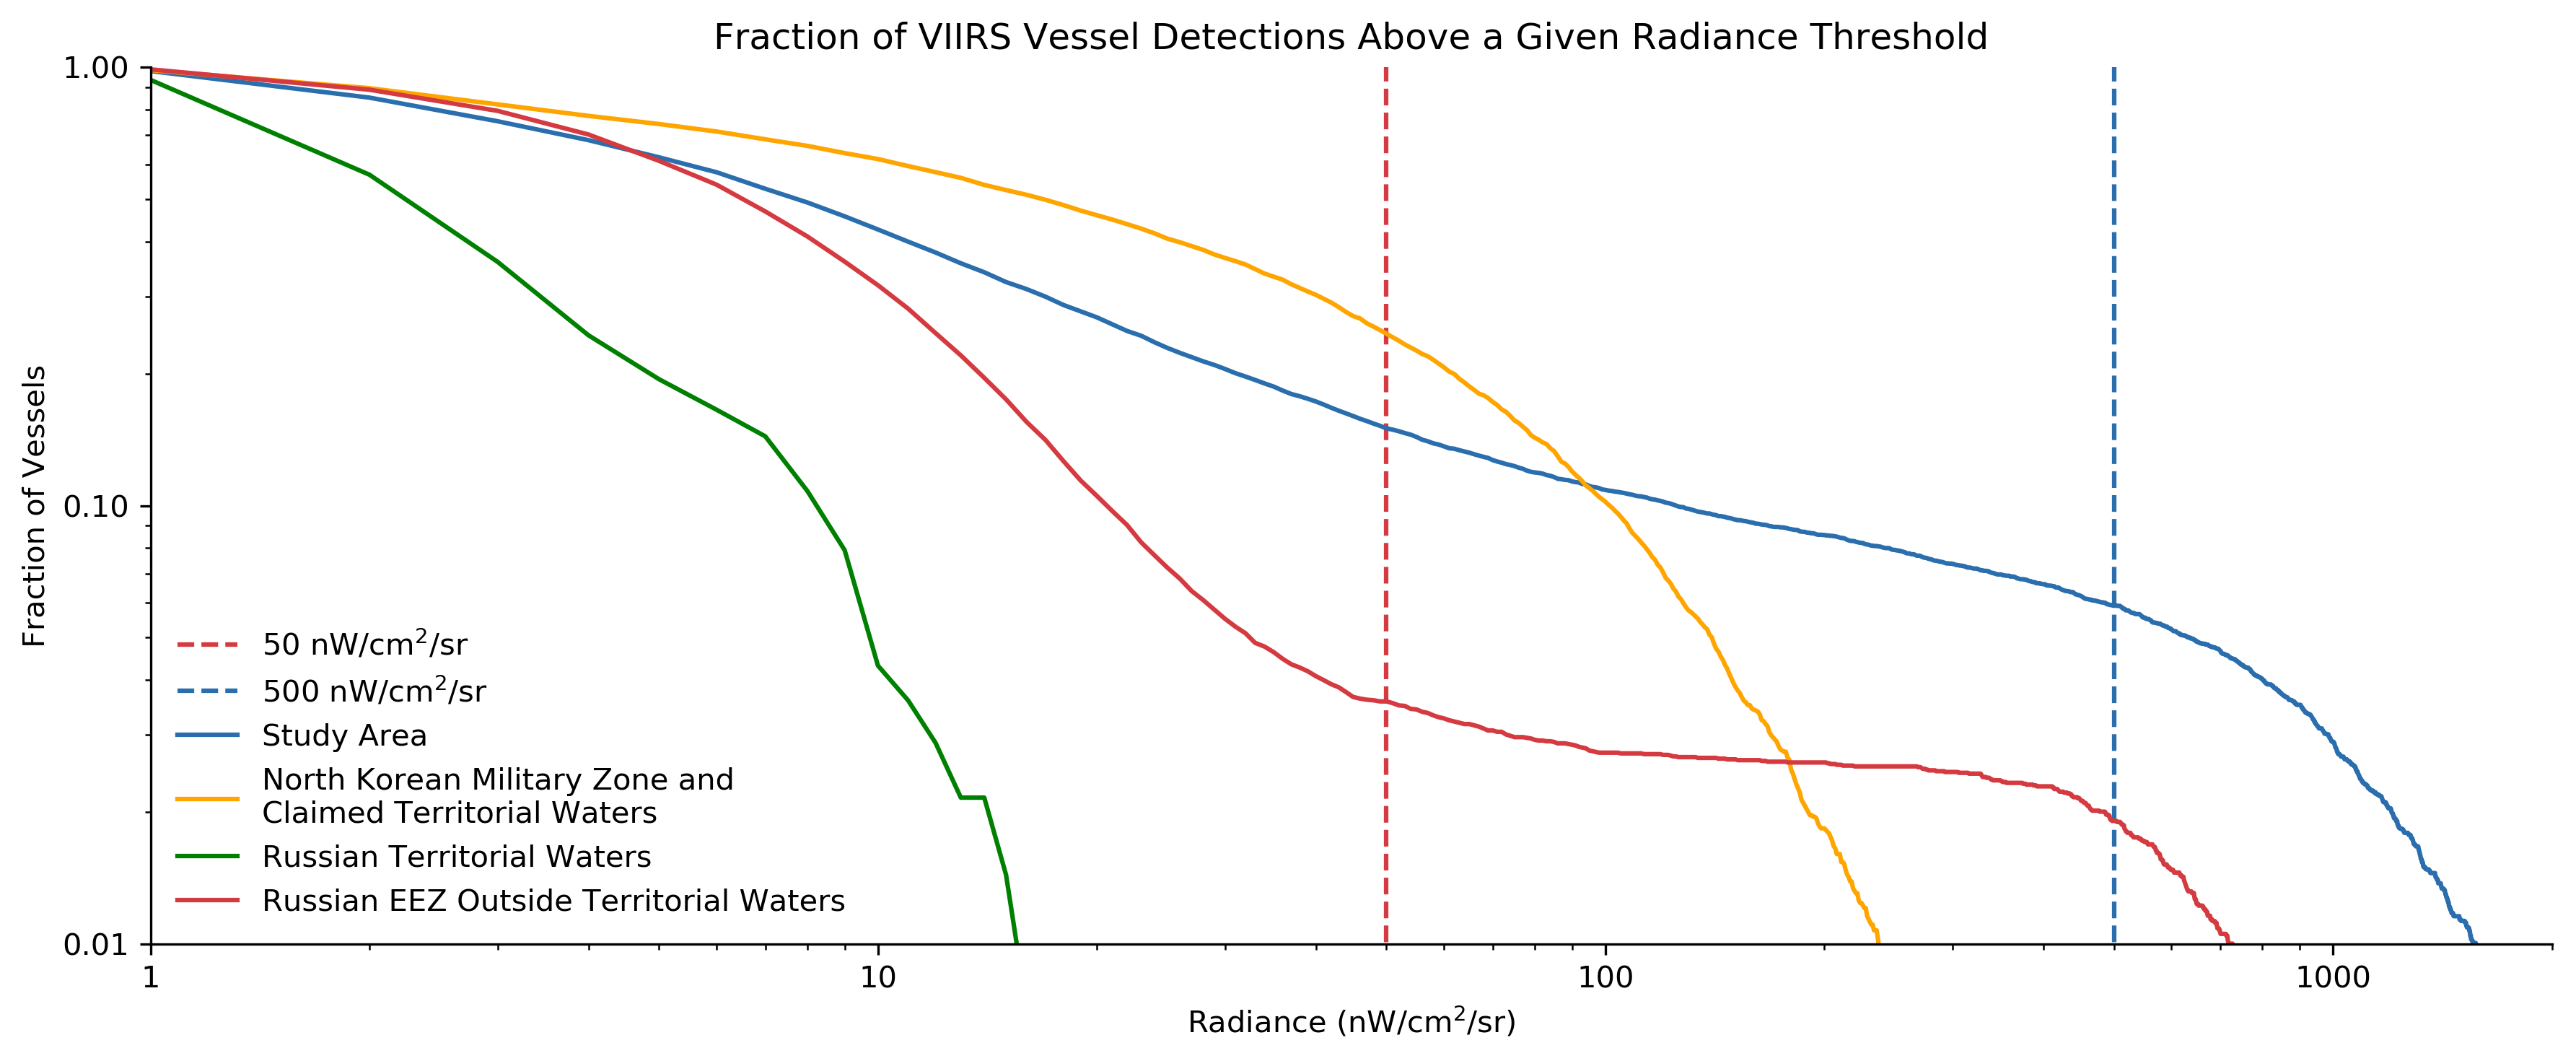

In [15]:
fig = plt.figure(figsize=(12,5), facecolor='white', dpi=300)
ax = plt.subplot(111)
plt.plot([50,50],[0,1], '--',color='#D43A40', label='50 nW/cm$^2$/sr')
plt.plot([500,500],[0,1], '--',color='#2A6EAD', label='500 nW/cm$^2$/sr')
plt.plot(radiances,stu/stu[0], color='#2A6EAD', label = 'Study Area')
plt.plot(radiances,prk_m/prk_m[0], color='orange', label = 'North Korean Military Zone and\nClaimed Territorial Waters')
plt.plot(radiances,rus_t/rus_t[0], color='green', label = 'Russian Territorial Waters')
plt.plot(radiances,rus_e/rus_e[0], color='#D43A40', label = 'Russian EEZ Outside Territorial Waters')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(loc='lower left', bbox_to_anchor=(0,0),frameon=False)
ax.set_yscale('log')
ax.set_xscale('log')
plt.title("Fraction of VIIRS Vessel Detections Above a Given Radiance Threshold")
plt.xlabel("Radiance (nW/cm$^2$/sr)")
plt.ylabel("Fraction of Vessels")
plt.ylim(.01,1)
plt.xlim(1,2e3)
ax.set_xticks([1, 10, 100, 1000])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.set_yticks([.01, .1, 1])
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.set_facecolor('none')
ax.grid(False)
fig.tight_layout()
plt.show()

# Fig S21. Days with the maximum number of VIIRS vessel detections


In [16]:
cmap_viirs = ("#FDC24B","#FA792F","#AD001D")
c = cmap_viirs

color_ramp = [[c[0],0,0],
          [c[1],50,50],
          [c[2],100,100]]

tm = 100.0
cdict = { 
    'red':tuple(   (color[2]/tm, 
                    int(color[0][1:3],16)/256.0, 
                    int(color[0][1:3],16)/256.0) for color in color_ramp ),
    'green':tuple( (color[2]/tm, 
                    int(color[0][3:5],16)/256.0, 
                    int(color[0][3:5],16)/256.0) for color in color_ramp ),
    'blue':tuple(  (color[2]/tm, 
                    int(color[0][5:7],16)/256.0, 
                    int(color[0][5:7],16)/256.0) for color in color_ramp )
}
cmap_viirs = colors.LinearSegmentedColormap('my_colormap',cdict,256)
cmap_viirs.set_bad(alpha = 0.0)

water = '#0A1738'
earth = '#37496D'

In [17]:
# 2018-10-13
# The day with the highest detection in Russian waters 

min_lon, min_lat, max_lon, max_lat = 130.992722, 39.195263, 138.834366, 44.991611

q = '''    
WITH
  viirs AS (
    select * 
    from (
      SELECT
          Lat_DNB AS lat,
          Lon_DNB AS lon,
          Date_Mscan,
          DATE (Date_Mscan) AS date,
          Rad_DNB as rad,
          SATZ_GDNBO
        FROM `global-fishing-watch.paper_dark_fishing_fleets_in_north_korea.viirs_raw_east_asia_2015_2018` 
        where date(Date_Mscan ) = date(timestamp('2018-10-13'))
        and QF_Detect in (1,2))
    where   lon > {min_lon}
        and lat > {min_lat}
        and lon < {max_lon}
        and lat < {max_lat}
  ),
  
  #
  # Preparation work for grouping detections by satellite overpass
  # because often one day gets multiple overpasses (usually two
  # overpasses per day with a gap of 1.5 hours between the two) 
  # with different satellite zenith.
  #
  overpass_block AS (
    SELECT
      * EXCEPT (block_start),
      MAX(block_start) OVER (
        PARTITION BY date 
        ORDER BY Date_Mscan 
        ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS overpass_group
    FROM (
      SELECT
        *,
        IF(TIMESTAMP_DIFF(Date_Mscan, prev_mscan, HOUR) >= 1,
          Date_Mscan, NULL) AS block_start
      FROM (
        SELECT
          *,
          LAG(Date_Mscan, 1, TIMESTAMP("2000-01-01")) OVER (
            PARTITION BY date 
            ORDER BY Date_Mscan ) AS prev_mscan
        FROM viirs ) )
  ),
  
  #
  # Select the best detection group per day (the best overpass per day,
  # usually two overpasses a day with a gap of 1.5 hours )
  # based on the number of detections per overpass (which is affected
  # by weather condition at the moment of image acquisition), except
  # if the acquisition was made with a mean satellite zenith >=60 degree, then
  # take the detection group that was made by an overpass with the lowest
  # satellite zenith of the day
  #
  best_daily_overpass AS (
    SELECT * EXCEPT (prev_mscan, overpass_group)
    FROM (
      SELECT
        *,
        MIN(mean_satz) OVER (PARTITION BY date) AS daily_min_mean_satz,
        MAX(mean_satz) OVER (PARTITION BY date) AS daily_max_mean_satz,
        MAX(num_detections) OVER (PARTITION BY date) AS daily_max_detections
      FROM (
        SELECT
          *,
          AVG(SATZ_GDNBO) OVER (PARTITION BY overpass_group) AS mean_satz,
          COUNT(*) OVER (PARTITION BY overpass_group) AS num_detections
        FROM overpass_block ) )
    #
    # If one of the overpasses was taken with an average zenith >=60 degrees,
    # then take the other detection group with the lowest zenith, othewise
    # take the group that has the higher number of detections.
    # And remove the remaining detections made with a zenith > 60 degrees.
    WHERE 
      ((daily_max_mean_satz >= 60 AND mean_satz = daily_min_mean_satz) 
      OR (daily_max_mean_satz < 60 AND num_detections = daily_max_detections))
      AND ABS(SATZ_GDNBO) < 60
  )
  
SELECT 
  lat, lon,
  Date_Mscan,
  rad,
  SATZ_GDNBO
FROM best_daily_overpass 
'''.format(min_lon=min_lon,min_lat=min_lat,max_lon=max_lon,max_lat=max_lat)
  
df_20181013 = pd.read_gbq(q, project_id='global-fishing-watch', dialect='standard')

In [18]:
# 2018-10-03
# The day with the highest detection in Study area

min_lat, min_lon, max_lat, max_lon = 38.126865, 129.426849, 42.068031, 134.884705

q = """
WITH
  viirs AS (
    select * 
    from (
      SELECT
          Lat_DNB AS lat,
          Lon_DNB AS lon,
          Date_Mscan,
          DATE (Date_Mscan) AS date,
          Rad_DNB as rad,
          SATZ_GDNBO
        FROM `global-fishing-watch.paper_dark_fishing_fleets_in_north_korea.viirs_raw_east_asia_2015_2018`  
        where date(Date_Mscan ) = date(timestamp('2018-10-03'))
        and QF_Detect in (1,2))
    where   lon > {min_lon}
        and lat > {min_lat}
        and lon < {max_lon}
        and lat < {max_lat}
  ),
  
  #
  # Preparation work for grouping detections by satellite overpass
  # because often one day gets multiple overpasses (usually two
  # overpasses per day with a gap of 1.5 hours between the two) 
  # with different satellite zenith.
  #
  overpass_block AS (
    SELECT
      * EXCEPT (block_start),
      MAX(block_start) OVER (
        PARTITION BY date 
        ORDER BY Date_Mscan 
        ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS overpass_group
    FROM (
      SELECT
        *,
        IF(TIMESTAMP_DIFF(Date_Mscan, prev_mscan, HOUR) >= 1,
          Date_Mscan, NULL) AS block_start
      FROM (
        SELECT
          *,
          LAG(Date_Mscan, 1, TIMESTAMP("2000-01-01")) OVER (
            PARTITION BY date 
            ORDER BY Date_Mscan ) AS prev_mscan
        FROM viirs ) )
  ),
  
  #
  # Select the best detection group per day (the best overpass per day,
  # usually two overpasses a day with a gap of 1.5 hours )
  # based on the number of detections per overpass (which is affected
  # by weather condition at the moment of image acquisition), except
  # if the acquisition was made with a mean satellite zenith >=60 degree, then
  # take the detection group that was made by an overpass with the lowest
  # satellite zenith of the day
  #
  best_daily_overpass AS (
    SELECT * EXCEPT (prev_mscan, overpass_group)
    FROM (
      SELECT
        *,
        MIN(mean_satz) OVER (PARTITION BY date) AS daily_min_mean_satz,
        MAX(mean_satz) OVER (PARTITION BY date) AS daily_max_mean_satz,
        MAX(num_detections) OVER (PARTITION BY date) AS daily_max_detections
      FROM (
        SELECT
          *,
          AVG(SATZ_GDNBO) OVER (PARTITION BY overpass_group) AS mean_satz,
          COUNT(*) OVER (PARTITION BY overpass_group) AS num_detections
        FROM overpass_block ) )
    #
    # If one of the overpasses was taken with an average zenith >=60 degrees,
    # then take the other detection group with the lowest zenith, othewise
    # take the group that has the higher number of detections.
    # And remove the remaining detections made with a zenith > 60 degrees.
    WHERE 
      ((daily_max_mean_satz >= 60 AND mean_satz = daily_min_mean_satz) 
      OR (daily_max_mean_satz < 60 AND num_detections = daily_max_detections))
      AND ABS(SATZ_GDNBO) < 60
  )
  
SELECT 
  lat, lon,
  Date_Mscan,
  rad,
  SATZ_GDNBO
FROM best_daily_overpass 
""".format(min_lon=min_lon,min_lat=min_lat,max_lon=max_lon,max_lat=max_lat)
  
df_20181003 = pd.read_gbq(q, project_id='global-fishing-watch', dialect='standard')

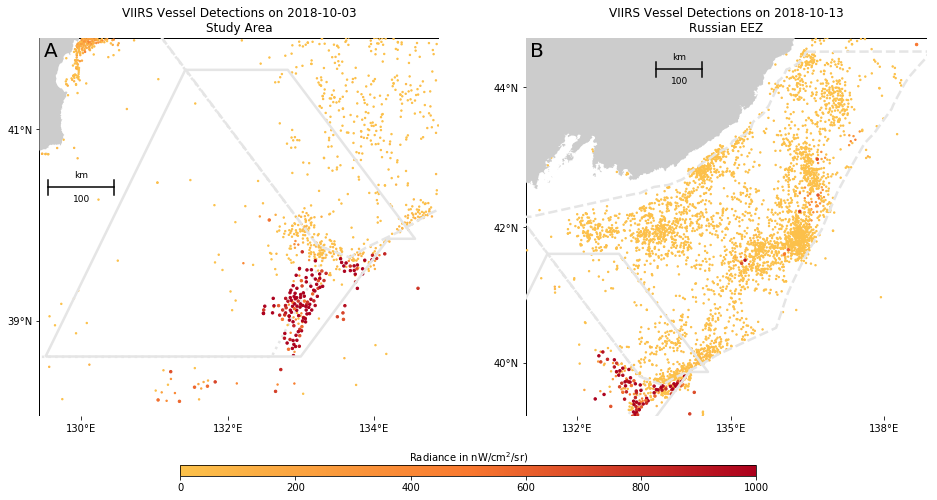

In [19]:
panel = ['A', 'B']
title = ["VIIRS Vessel Detections on 2018-10-03\nStudy Area",
         "VIIRS Vessel Detections on 2018-10-13\nRussian EEZ"]
extent = [[37.976865, 129.426849, 42.238031, 134.884705],
          [39.195263, 130.992722, 44.991611, 138.834366]]
lon_tics = [[130, 132, 134],
            [132, 135, 138]]
lat_tics = [[39, 41],
            [40, 42, 44]]
scale_lon_lat = [[130, 40.4],
                 [134, 44.25]]

cmap = cmap_viirs
fig_min_value, fig_max_value = 0, 1000
norm = colors.Normalize(vmin=fig_min_value, vmax=fig_max_value)

def viirs_plot_single_date(ax, df, i):

    ax.text(0.01, 0.95, panel[i], transform=ax.transAxes, fontsize=20)
    ax.set_title(title[i], fontsize=12)

    min_lat, min_lon, max_lat, max_lon = extent[i]
    

    m = Basemap(ax=ax, projection='merc', 
                lat_0 = min_lat/2. + max_lat/2., 
                lon_0 = min_lon/2. + max_lon/2.,
                resolution = 'h', area_thresh = 0.1,
                llcrnrlon=min_lon, llcrnrlat=min_lat,
                urcrnrlon=max_lon, urcrnrlat=max_lat-.3)

    ## Read boundary shapefiles
    m.readshapefile(_study_area,'sa', zorder=1.5,
                    linewidth=2.5, color='#E5E5E5')
    prk = m.readshapefile(_eez_prk_no_shoreline, 'prk', zorder=1.,
                          linewidth=2.5, color='#e5e5e5')
    prk[-1].set_linestyle(':')
    
    rus = m.readshapefile(_eez_rus_near_prk_wo_12nm, 'rus', zorder=1.5,
                          linewidth=2.5, color='#E5E5E5')
    rus[-1].set_linestyle("--")

    m.fillcontinents(color = "#CCCCCC" , lake_color = "#CCCCCC")
    m.drawmapboundary(fill_color="white")

    # Plot detections with a low radiance
    d = df[df.rad < 500]
    x, y = m(list(d.lon), list(d.lat))
    markersize=2
    m.scatter(x, y, c=d.rad, alpha = 1, cmap = cmap, s=markersize, norm=norm)

    # Plot detections with a high radiance
    d = df[df.rad > 500]
    x, y = m(list(d.lon), list(d.lat))
    markersize=6
    m.scatter(x, y, c=d.rad, alpha = 1, cmap = cmap, s=markersize, norm=norm)

    raw_tic_locs = lon_tics[i]
    tic_locs, _ = m(raw_tic_locs, [min_lat] * len(raw_tic_locs))
    ax.set_xticks(tic_locs)
    ax.set_xticklabels([u"{}\u00b0E".format(x) for x in raw_tic_locs])

    raw_tic_locs = lat_tics[i]
    _, tic_locs = m([min_lat] * len(raw_tic_locs), raw_tic_locs)
    ax.set_yticks(tic_locs)
    ax.set_yticklabels([u"{}\u00b0N".format(x) for x in raw_tic_locs])

    m.drawmapscale(scale_lon_lat[i][0], scale_lon_lat[i][1], 
                   scale_lon_lat[i][0], scale_lon_lat[i][1], 
                   100, barstyle='simple', units='km', fontsize=9, 
                   yoffset=None, labelstyle='simple', fontcolor='k', 
                   fillcolor1='w', fillcolor2='k', ax=None, format='%d', zorder=None)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.grid(False)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,7.2))
viirs_plot_single_date(ax1, df_20181003, 0)
viirs_plot_single_date(ax2, df_20181013, 1)

ax = fig.add_axes([0.25, 0.035, 0.5, 0.02])
cb = colorbar.ColorbarBase(ax, norm = norm, orientation='horizontal', cmap = cmap)
cb.set_label('Radiance in nW/cm$^2$/sr)',labelpad=-43, y=0.45, color = "#000000")

plt.gcf().subplots_adjust(bottom=0.15)

plt.show()

# Fig.S22. Sensitivity of the estimated number of vessels and vessel days to radiance thresholds for the North Korean fleet operating in the Russian EEZ

In [20]:
# this query gets all detections on the days with the most detections in each 15 day period across
# 2015-2018. Note that this is slightly different than the method used in other parts of the paper,
# which divide each month in half. This figure is merely to produce a sensitivity analysis, so
# it results in only a very slightly different result

q = ''' 

WITH
  top_date AS (
  SELECT
    date,
    day_period
  FROM (
    SELECT
      ROW_NUMBER() OVER (PARTITION BY day_period, year ORDER BY vessels DESC, rand() DESC) AS row_number,
      date,
      day_period,
      vessels
    FROM (
      SELECT
        extract(year from Date_Mscan ) year,
        CAST(FLOOR(EXTRACT(dayofyear
            FROM
              Date_Mscan)/15) AS int64) AS day_period,
        DATE(Date_Mscan) date,
        SUM(Rad_DNB) total_radiance,
        COUNT(*) vessels
      FROM
        `global-fishing-watch.paper_dark_fishing_fleets_in_north_korea.viirs_rus_eez_wo_12nm_2015_2018`
      GROUP BY
        date,
        year,
        day_period
      ORDER BY
        date ) )
  WHERE
    row_number = 1)
  #
  #
  #
SELECT
  Lat_DNB AS lat,
  Lon_DNB AS lon,
  DATE(Date_Mscan) AS date,
  Rad_DNB AS rad,
  SATZ_GDNBO
FROM
  `global-fishing-watch.paper_dark_fishing_fleets_in_north_korea.viirs_rus_eez_wo_12nm_2015_2018`
WHERE
  DATE(Date_Mscan) IN (
  SELECT
    date
  FROM
    top_date)
'''
df = pd.read_gbq(q, project_id='global-fishing-watch', dialect='standard')

In [21]:
# get the day with the most data
top_date = ''
n = 0
for the_date in df.date.unique():
    a = (df.date==the_date).sum()
    if a>n:
        n=a
        top_date = the_date

# Create an array, num_vessels, that is the number of detections
# on that dat with a radiance above a given threshold
d = df[df.date==top_date]
radiances = [i for i in range(100)]
num_vessels = []
for radiance in radiances:
    num_vessels.append(len(d[d.rad < radiance]))
num_vessels = np.array(num_vessels)

In [22]:
# Calculate Vessel Days below a given radiance

radiances = [i for i in range(100)]
vessel_days = []
for radiance in radiances:
    vessel_days.append(len(df[df.rad<radiance]))
vessel_days = np.array(vessel_days)*(15) 
vessel_days = vessel_days / 1000 # convert to 1,000 vessel days

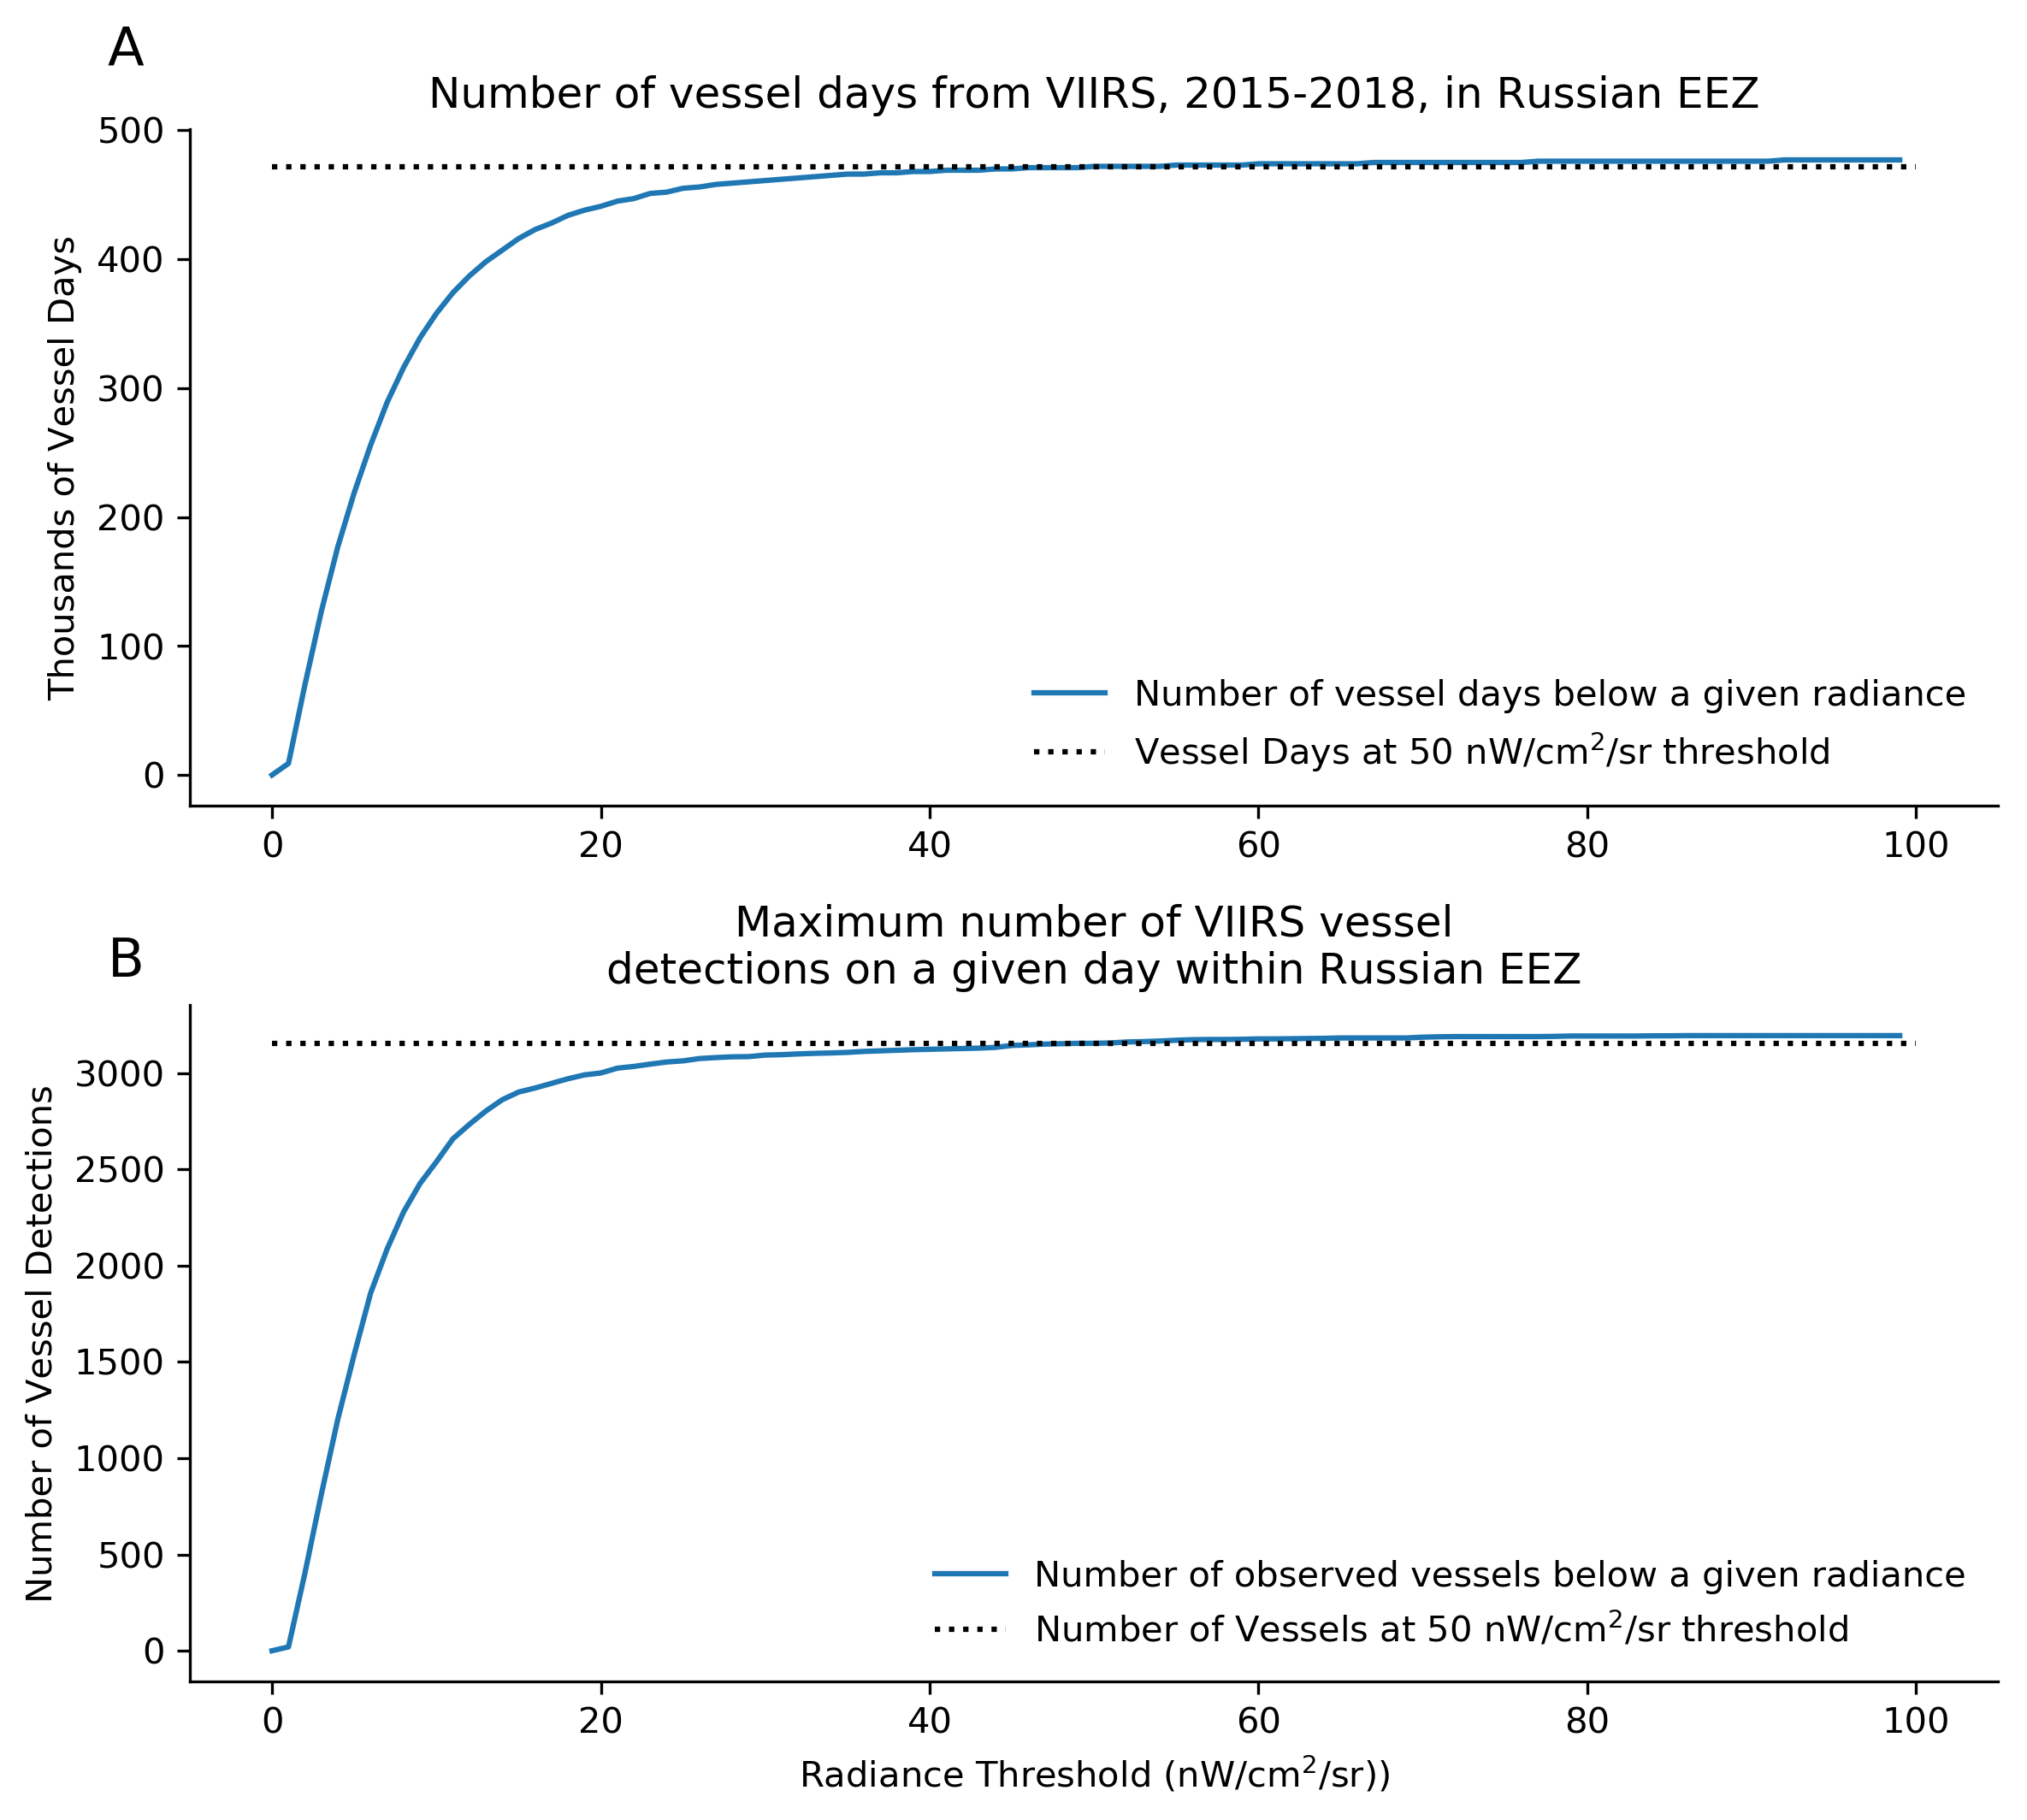

In [23]:
fig = plt.figure(figsize=(8,7), dpi=300, facecolor='white')

ax1 = plt.subplot(2, 1, 1)
ax1.plot(radiances,vessel_days, label='Number of vessel days below a given radiance')
ax1.plot([0,100],[vessel_days[50],vessel_days[50]], ':',color='black',
         label='Vessel Days at 50 nW/cm$^2$/sr threshold')
ax1.legend(frameon=False)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.grid(False)
ax1.set_facecolor('white')
plt.ylabel("Thousands of Vessel Days") 
plt.title("Number of vessel days from VIIRS, 2015-2018, in Russian EEZ")
plt.text (-10,550,"A",fontsize=15)


ax2 =  plt.subplot(2, 1, 2)      
ax2.plot(radiances,num_vessels, label='Number of observed vessels below a given radiance')
ax2.plot([0,100],[num_vessels[50],num_vessels[50]], ':',color='black',
         label='Number of Vessels at 50 nW/cm$^2$/sr threshold')
ax2.legend(frameon=False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.grid(False)
ax2.set_facecolor('white')
plt.xlabel("Radiance Threshold (nW/cm$^2$/sr))")
plt.ylabel("Number of Vessel Detections") 
plt.title("Maximum number of VIIRS vessel\ndetections on a given day within Russian EEZ")

plt.tight_layout() 
plt.text (-10,3500,"B",fontsize=15)
plt.show()

## Fig.S23. Sensitivity of the estimated number of vessels and vessel days to radiance thresholds for Chinese lighting vessels operating in our study area. 


In [24]:
q = '''SELECT
  Lat_DNB AS lat,
  Lon_DNB AS lon,
  date(Date_Mscan) AS date,
  Rad_DNB as rad,
  SATZ_GDNBO
FROM
  `global-fishing-watch.paper_dark_fishing_fleets_in_north_korea.viirs_study_area_2017`
  '''
df_2017 = pd.read_gbq(q, project_id='global-fishing-watch', dialect='standard')

In [25]:
q = '''SELECT
  Lat_DNB AS lat,
  Lon_DNB AS lon,
  date(Date_Mscan) AS date,
  Rad_DNB as rad,
  SATZ_GDNBO
FROM
  `global-fishing-watch.paper_dark_fishing_fleets_in_north_korea.viirs_study_area_2018`
  '''
df_2018 = pd.read_gbq(q, project_id='global-fishing-watch', dialect='standard')

In [26]:
# Calculate the max Number of Vessels for different thresholds
radiances = np.arange(0,1000,2) 
max_vessels_2017 = []
max_vessels_2018 = []
for radiance in radiances:
    d_2017 = df_2017[df_2017.rad > radiance]
    max_value = d_2017.groupby('date').count().lat.max()
    max_vessels_2017.append(max_value)
    d_2018 = df_2018[df_2018.rad > radiance]
    max_value = d_2018.groupby('date').count().lat.max()
    max_vessels_2018.append(max_value)

In [27]:
# Number of days in each half month period across the year
# because 2018 and 2017 are not leap years, we can use this for both
# If you try this for a leap year, you will need to change the code
num_days = [15 if i%2 == 0 else calendar.monthrange(2017, i//2 + 1)[1] - 15 for i in range(12 * 2)]

# Index of the end date of the half-month window 
end_index = np.cumsum(np.array(num_days)) - 1

# Index of the start date of the half-month window
start_index = [0] + list(end_index + 1)

def get_vessel_days(df, radiances, startdate, enddate):
    the_dates = pd.date_range(startdate,enddate)
    vessel_days = []
    for radiance in radiances:
        n=0
        d = df[df.rad > radiance]
        d = d.groupby('date').count().rad.to_frame()
        #
        # Calculate fishing days per rad threshold
        for start, end, num_day in zip(start_index, end_index, num_days):
            df_half_month = d[(d.index >= the_dates[start]) & (d.index < the_dates[end])]
            if len(df_half_month) > 0:
                n += df_half_month.rad.max() * num_day
        vessel_days.append(n)  
        
    return vessel_days


startdate = datetime.datetime(2017,1,1)
enddate = datetime.datetime(2017,12,31)
y_2017_vessel_days = get_vessel_days(df_2017, radiances, startdate, enddate)

startdate = datetime.datetime(2018,1,1)
enddate = datetime.datetime(2018,12,31)
y_2018_vessel_days = get_vessel_days(df_2018, radiances, startdate, enddate)


In [28]:
vessel_days =  np.add(np.array(y_2017_vessel_days),np.array(y_2018_vessel_days))

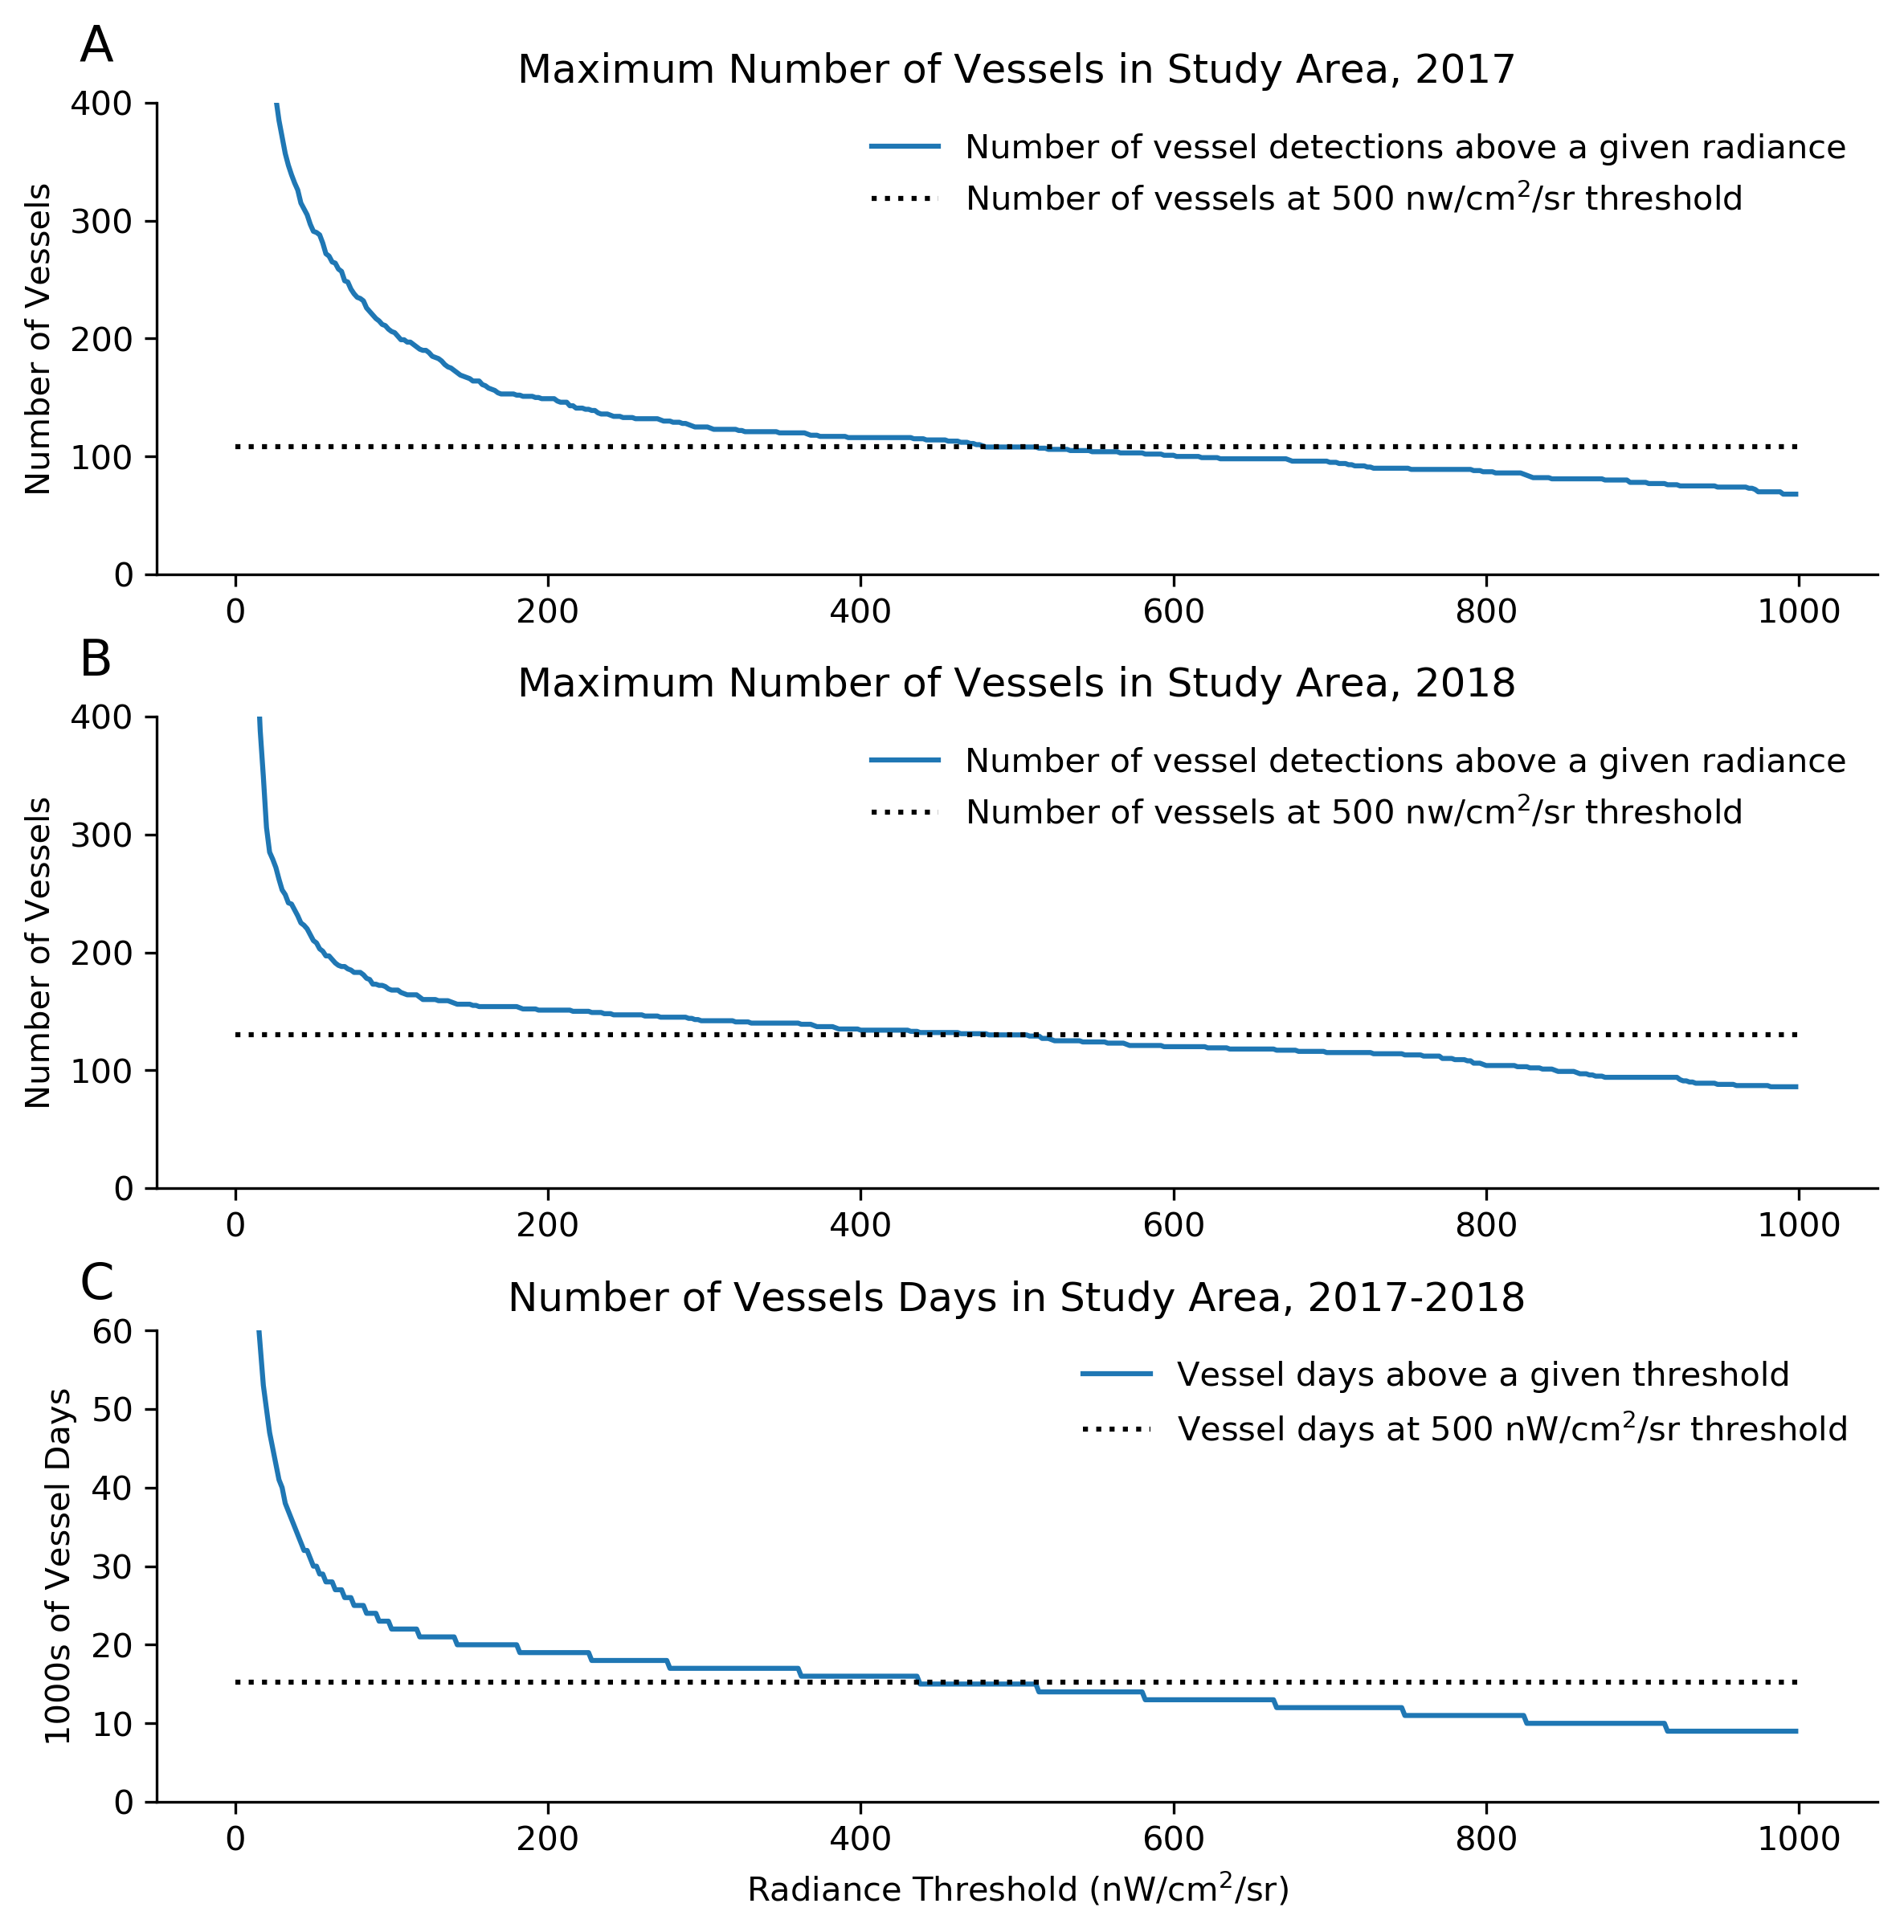

In [29]:
fig = plt.figure(figsize=(8,8), dpi=300, facecolor='white')
ax1 = plt.subplot(3, 1, 1)

ax1.plot(radiances,max_vessels_2017, label = "Number of vessel detections above a given radiance")
ax1.plot([0,1000],[max_vessels_2017[250],max_vessels_2017[250]], ':',color='black',
         label='Number of vessels at 500 nw/cm$^2$/sr threshold')
# plt.xlabel("Radiance Threshold (nW/cm$^2$/sr)")
plt.ylabel("Number of Vessels")
plt.title("Maximum Number of Vessels in Study Area, 2017")
plt.legend(frameon=False)
plt.ylim(0,400)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.grid(False)
ax1.set_facecolor('white')
plt.text (-100,435,"A",fontsize=15)# y, s,


ax2 = plt.subplot(3, 1, 2)
ax2.plot(radiances,max_vessels_2018, label = "Number of vessel detections above a given radiance")
ax2.plot([0,1000],[max_vessels_2018[250],max_vessels_2018[250]], ':',color='black',
         label='Number of vessels at 500 nw/cm$^2$/sr threshold')
# plt.xlabel("Radiance Threshold (nW/cm$^2$/sr)")
plt.ylabel("Number of Vessels")
plt.title("Maximum Number of Vessels in Study Area, 2018")
plt.legend(frameon=False)
plt.ylim(0,400)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.grid(False)
ax2.set_facecolor('white')

plt.text (-100,435,"B",fontsize=15)# y, s,


ax3 = plt.subplot(3, 1, 3)

ax3.plot(radiances,vessel_days/1000, label = "Vessel days above a given threshold")
# plt.plot(x,y, label = "Number of vessel days above a given radiance")
ax3.plot([0,1000],[vessel_days[250]/1000.,vessel_days[250]/1000.], ':',color='black',
         label='Vessel days at 500 nW/cm$^2$/sr threshold')
plt.ylim(0,60)
plt.ylabel("1000s of Vessel Days")
plt.xlabel("Radiance Threshold (nW/cm$^2$/sr)")
plt.title("Number of Vessels Days in Study Area, 2017-2018")
plt.legend(frameon=False)
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax3.grid(False)
ax3.set_facecolor('white')
plt.text (-100,64,"C",fontsize=15)# y, s,

plt.tight_layout()
plt.show()

## Fig.S24 - Comparison of fishing and non-fishing seasons, as detected by VIIRS in 2017

In [30]:
q = """
#StandardSQL  
SELECT *
FROM `paper_dark_fishing_fleets_in_north_korea.viirs_east_asia_2017`
"""
all_detections_2017 = pd.read_gbq(q, project_id='global-fishing-watch', dialect='standard')

In [31]:
all_detections_2017['Date_Mscan'] = all_detections_2017['Date_Mscan']\
                                        .apply(lambda x: x.tz_convert(None))

In [32]:
def half_monthly_best(df_orig, startdate, enddate):
    
    df = df_orig.copy()
    df['date'] = df['Date_Mscan'].apply(lambda x: x.strftime('%Y/%m/%d'))
    startdate = datetime.datetime.strptime(startdate, "%Y%m%d")
    enddate = datetime.datetime.strptime(enddate, "%Y%m%d")

    daily_nums = []
    
    #
    # Loop through daily detections to filter VIIRS detection 
    # for the period of interest and categorize detections by intensity
    #
    date = startdate
    while date < enddate:
        datestr = "{:%Y/%m/%d}".format(date)
        daily_nums.append((df['date'] == datestr).sum())
        
        date += datetime.timedelta(days=1)


    window_length = [15, 16, 15, 13, 15, 16, 15, 15, 15, 16, 15, 15, 
                     15, 16, 15, 16, 15, 15, 15, 16, 15, 15, 15, 16]

    max_filtered = pd.DataFrame([])
    temp_max = 0 
    temp_max_idx = 0
    i = 0
    count = 0

    for idx, n in enumerate(daily_nums):
        if n >= temp_max:
            temp_max = n
            temp_max_idx = idx
        if count < window_length[i]-1:  
            count += 1
            continue
        else:
            date = startdate + datetime.timedelta(days=temp_max_idx)
            date = datetime.datetime.strftime(date, "%Y/%m/%d")
            #
            # Collect the detections of the day that is the half-monthly best
            half_month_max = df[df['date'] == date]
            max_filtered = pd.concat([max_filtered, 
                                      half_month_max], 
                                     ignore_index=True)
            temp_max = 0
            count = 0
            i += 1
            
    return max_filtered

In [33]:
#
# Plot the VIIRS detections by a given intensity category
# in two panel to compare between fishing and non-fishing 
# seasons.
#
def compare_viirs(df, cat, title1, title2):
    """
    df: DataFrame, VIIRS detection data set
    cat: String, detection range category
    title1: String, title for the left panel
    title2: String, title for the right panel
    """
    
    #
    # Set the default map setting
    lllon = 126.5
    urlon = 139.5
    lllat = 35
    urlat = 45
    
    #
    # Set the detection radiance ranges for each category
    if cat == 'high':
        rad_lower, rad_upper = 500, 10000
    elif cat == 'mid':
        rad_lower, rad_upper = 50, 500
    elif cat == 'low':
        rad_lower, rad_upper = 0, 50
    else:
        raise ValueError("Unknown radiance category given.")
        
    #
    # Index each category for easy reference below
    cat_idx = {'high': 2, 'mid': 1, 'low': 0}
    
    #
    # Set time
    year=2017
    df['date'] = df['Date_Mscan'].apply(lambda x: x.strftime('%Y/%m/%d'))
    startdate = datetime.datetime(year, 1, 1)
    enddate = datetime.datetime(year + 1, 1, 1)
    
    df_filtered = pd.DataFrame([])

    #
    # Daily VIIRS detection to plot
    df_date_range = df[(df.date >= datetime.datetime.strftime(startdate, "%Y/%m/%d")) & 
                        (df.date < datetime.datetime.strftime(enddate, "%Y/%m/%d"))]
    df_filtered = df_date_range[(df_date_range['Rad_DNB'] >= rad_lower) &
                                    (df_date_range['Rad_DNB'] < rad_upper)]
    
    #
    # Map configurations (font option: #fontproperties=rbt_reg)
    fig = plt.figure(figsize=(12,5.5), facecolor='white', dpi=300)
    fig.text(.033,0.90, title1, fontsize=24, ha='left') 
    fig.text(.525,0.90, title2, fontsize=24, ha='left')
    
    #
    # Loop twice for two panels of the same radiance range
    # but for two different seasons
    for n in range(2):
        if n == 0:
            dfn = df_filtered[
                (df_filtered['Date_Mscan'] >= pd.to_datetime('20170514')) &
                (df_filtered['Date_Mscan'] <= pd.to_datetime('20171211'))]
        else:
            dfn = df_filtered[
                (df_filtered['Date_Mscan'] < pd.to_datetime('20170514')) |
                (df_filtered['Date_Mscan'] > pd.to_datetime('20171211'))]
        
        #
        # Some more map configurations
        ax = fig.add_subplot('12{}'.format(n+1))
        m = Basemap(llcrnrlon=lllon, llcrnrlat=lllat,
                    urcrnrlon=urlon, urcrnrlat=urlat,
                    lat_ts=0, projection='mill', resolution="l")
        m.drawmapboundary(fill_color='white', color='white', zorder=0.5)
        m.fillcontinents(color='#E5E5E5', lake_color='#E5E5E5', zorder=1)
        m.drawcountries(color='white', linewidth=1.5)
        
        #
        # Read boundary shapefiles
        m.readshapefile(_study_area,'prk', zorder=2.5,
                        linewidth=1.5, color='#E5E5E5')
        prk = m.readshapefile(_eez_prk_wo_mz, 'prk', zorder=2.5,
                              linewidth=1.5, color='#E5E5E5')
        prk[-1].set_linestyle('--')
        mz = m.readshapefile(_eez_prk_mz, 'mz', zorder=2.5,
                             linewidth=1.5, color='#E5E5E5')
        mz[-1].set_linestyle('--')
        m.plot([], [], linewidth=1.5, alpha=0.8, 
               color='#CCCCCC', label='Study area')
        m.plot([], [], linewidth=1.5, linestyle='--', alpha=0.8, 
               color='#CCCCCC', label='EEZ claimed by N.Korea')

        #
        # Set axes and ticks
        gap_lat = 4
        gap_lon = 5
        med_lat = 40.0
        med_lon = 133.0
        num_tick_lat = 3
        num_tick_lon = 3
        
        if n==0:
            m.drawparallels(np.arange(med_lat-gap_lat, 
                                      med_lat+gap_lat+1, 
                                      gap_lat),
                            labels=[1,0,0,0], linewidth=0.01, zorder=0)
            
        m.drawmeridians(np.arange(med_lon-gap_lon, 
                                  med_lon+gap_lon+1, 
                                  gap_lon),
                        labels=[0,0,0,1], linewidth=0.01, zorder=0)

        #
        # Set ranges and colors as per index we set above
        r_range = [0,200,200,10000]
        c_range = ['#fecc5c','#fd8d3c','#bd0026'] #f03b20
        lon = dfn['Lon_DNB'].values
        lat = dfn['Lat_DNB'].values
        lon, lat = m(lon, lat)
        label = ['Light detection (0-50 $nW/cm^2/sr$)',
                 'Light detection (50-500 $nW/cm^2/sr$)',
                 'Light detection (>500 $nW/cm^2/sr$)']
        #
        # Plot a scatter map
        m.scatter(lon, lat, c=c_range[cat_idx[cat]], s=4, alpha=0.4, 
                  edgecolors='face', zorder=2, label=label[cat_idx[cat]])
        
        #
        # Create legend (font option: #prop=rbt_reg)
        if n == 1:
            handles, labels = plt.gca().get_legend_handles_labels()
            order = [2,0,1]
            leg = plt.legend([handles[idx] for idx in order],
                             [labels[idx] for idx in order], 
                             bbox_to_anchor=(1.0, 0.0), loc=4, frameon=True, 
                             markerscale=4, labelspacing=0.3)  

            for text in leg.get_texts():
                text.set_color("black")
                text.set_fontsize(14)
            for lh in leg.legendHandles: 
                lh.set_alpha(1)
                
            frame = leg.get_frame()
            frame.set_facecolor('white')
            frame.set_edgecolor('#e5e5e5')
            frame.set_linewidth(1.5)
            frame.set_alpha(0.9)

        #
        # axes, figures
        ax = plt.gca()
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        
    fig.tight_layout()
    plt.show()

In [34]:
all_detections_2017_halfmonthly_max = half_monthly_best(all_detections_2017, 
                                                        '20170101', '20180101')

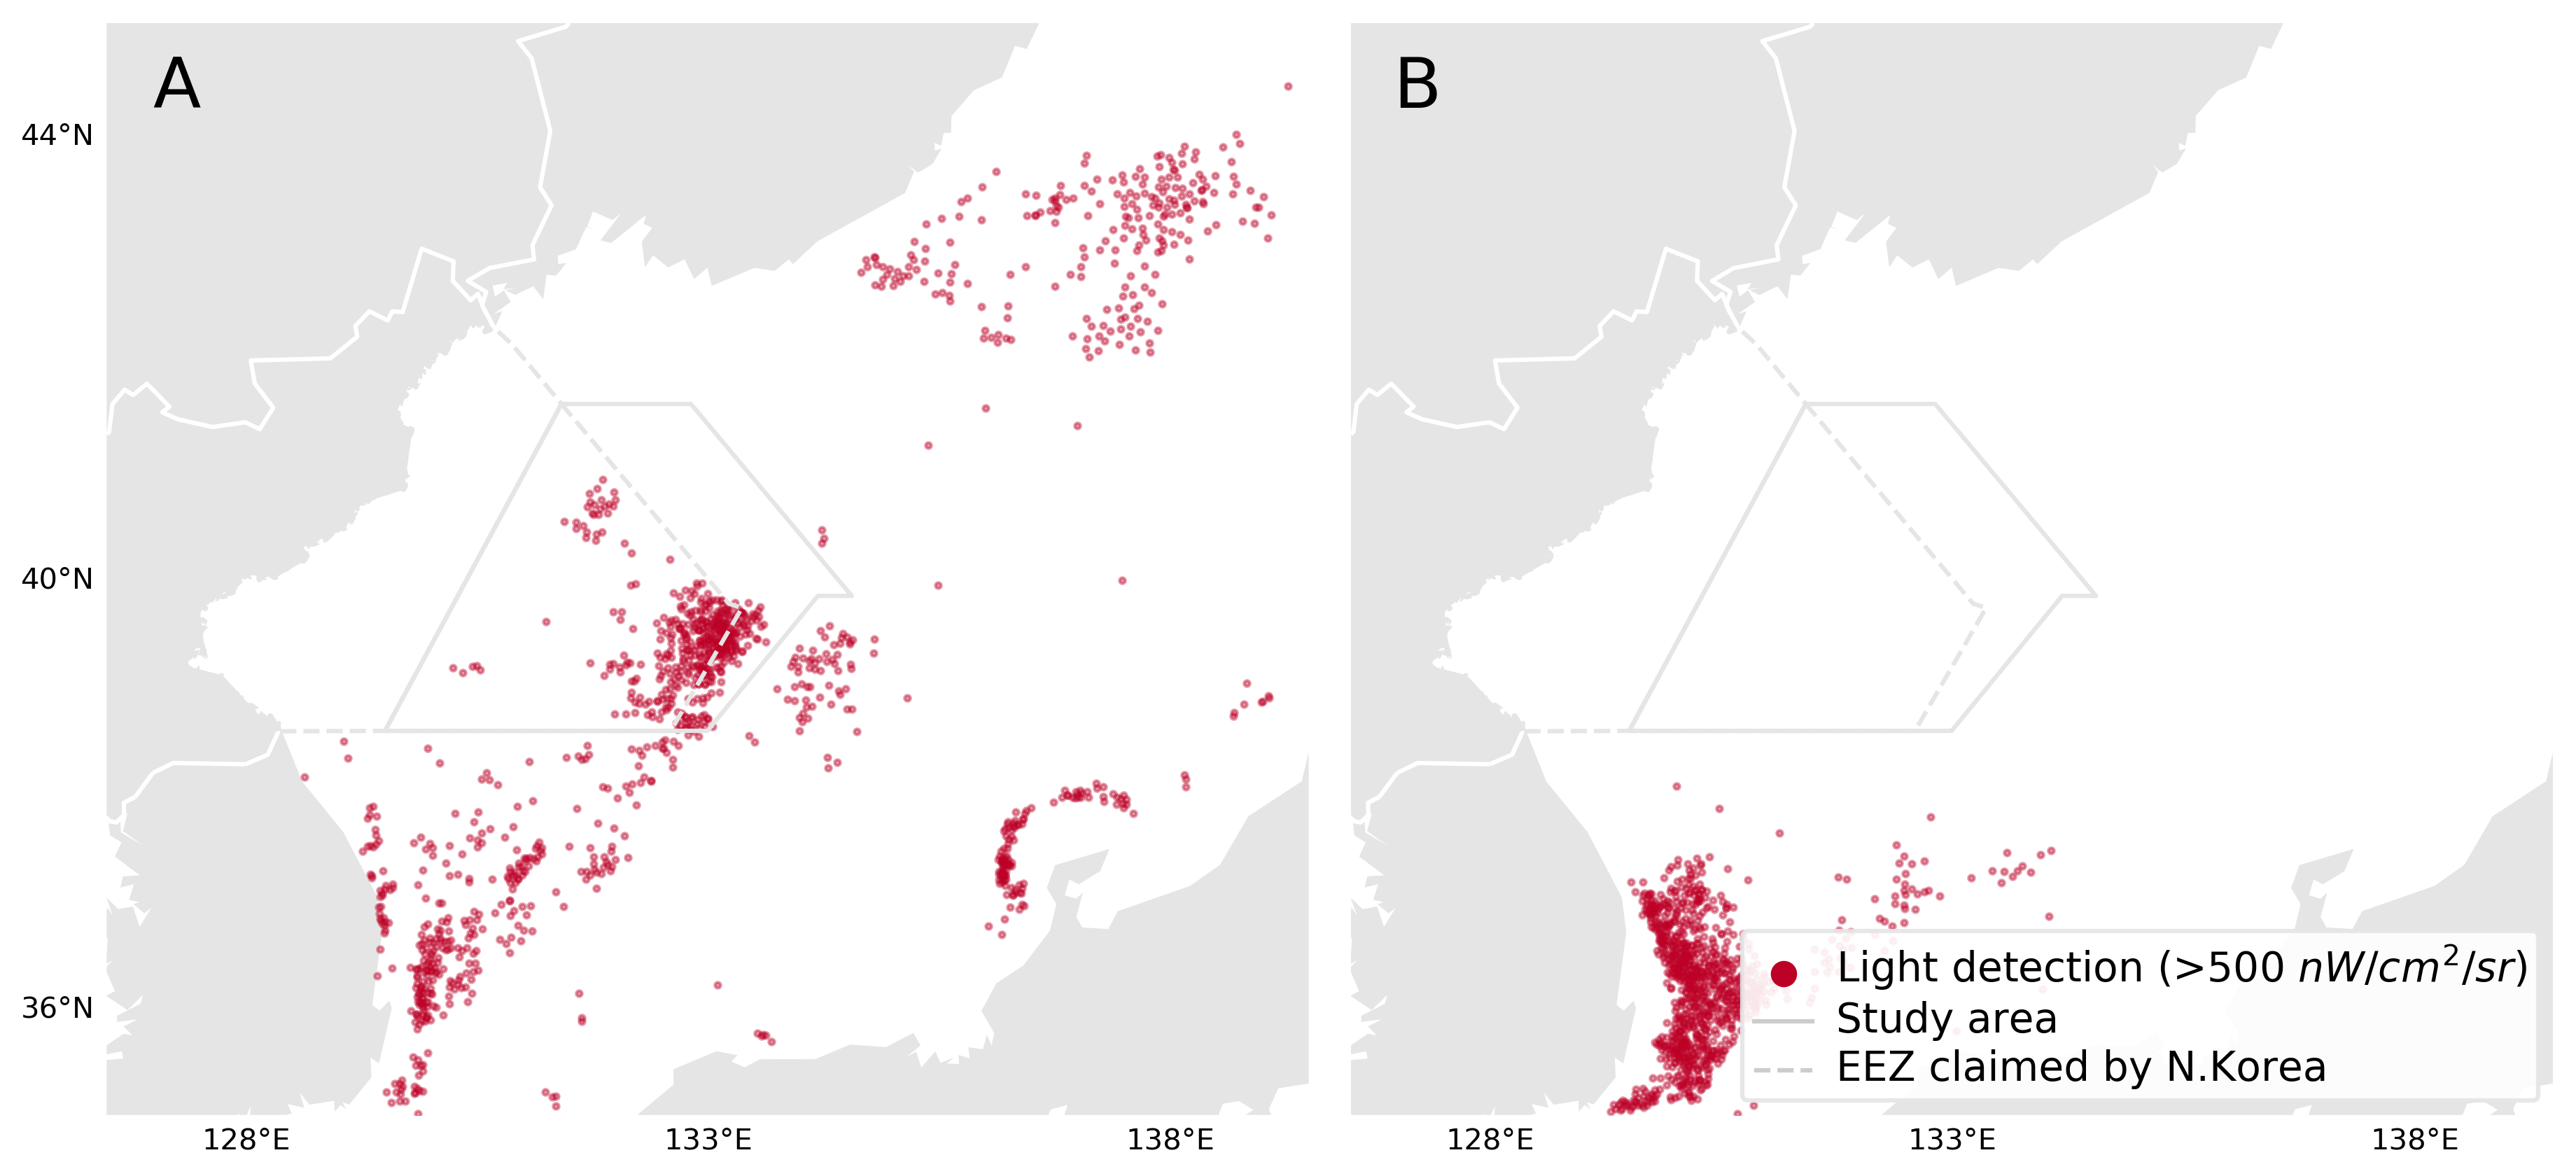

In [35]:
compare_viirs(all_detections_2017_halfmonthly_max, 'high', 'A', 'B')

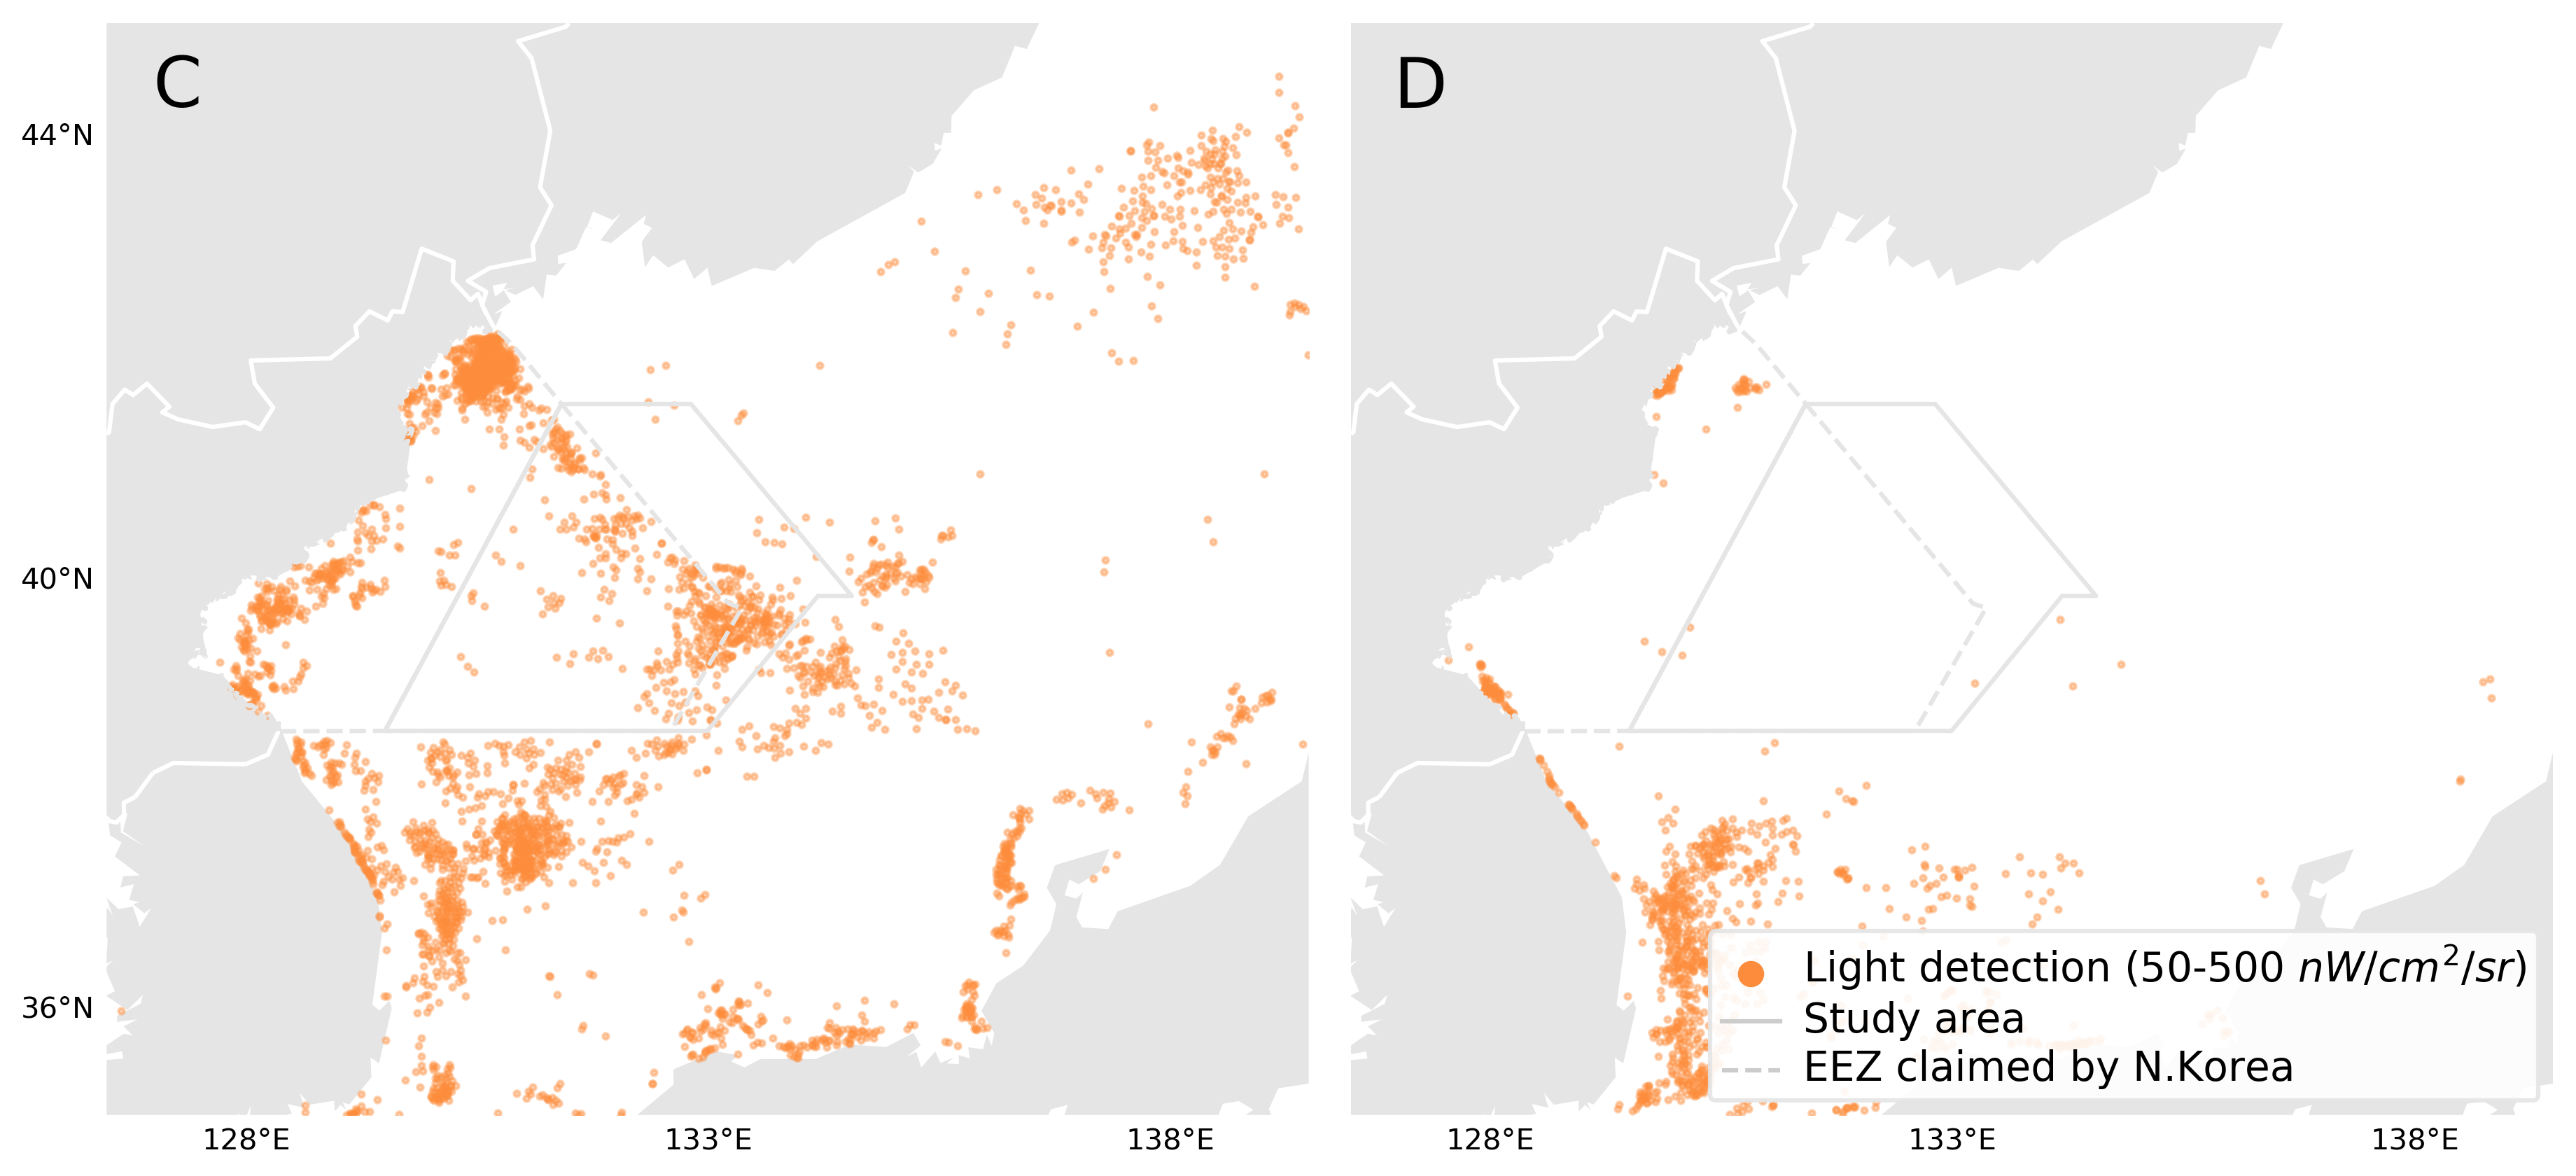

In [36]:
compare_viirs(all_detections_2017_halfmonthly_max, 'mid', 'C', 'D')

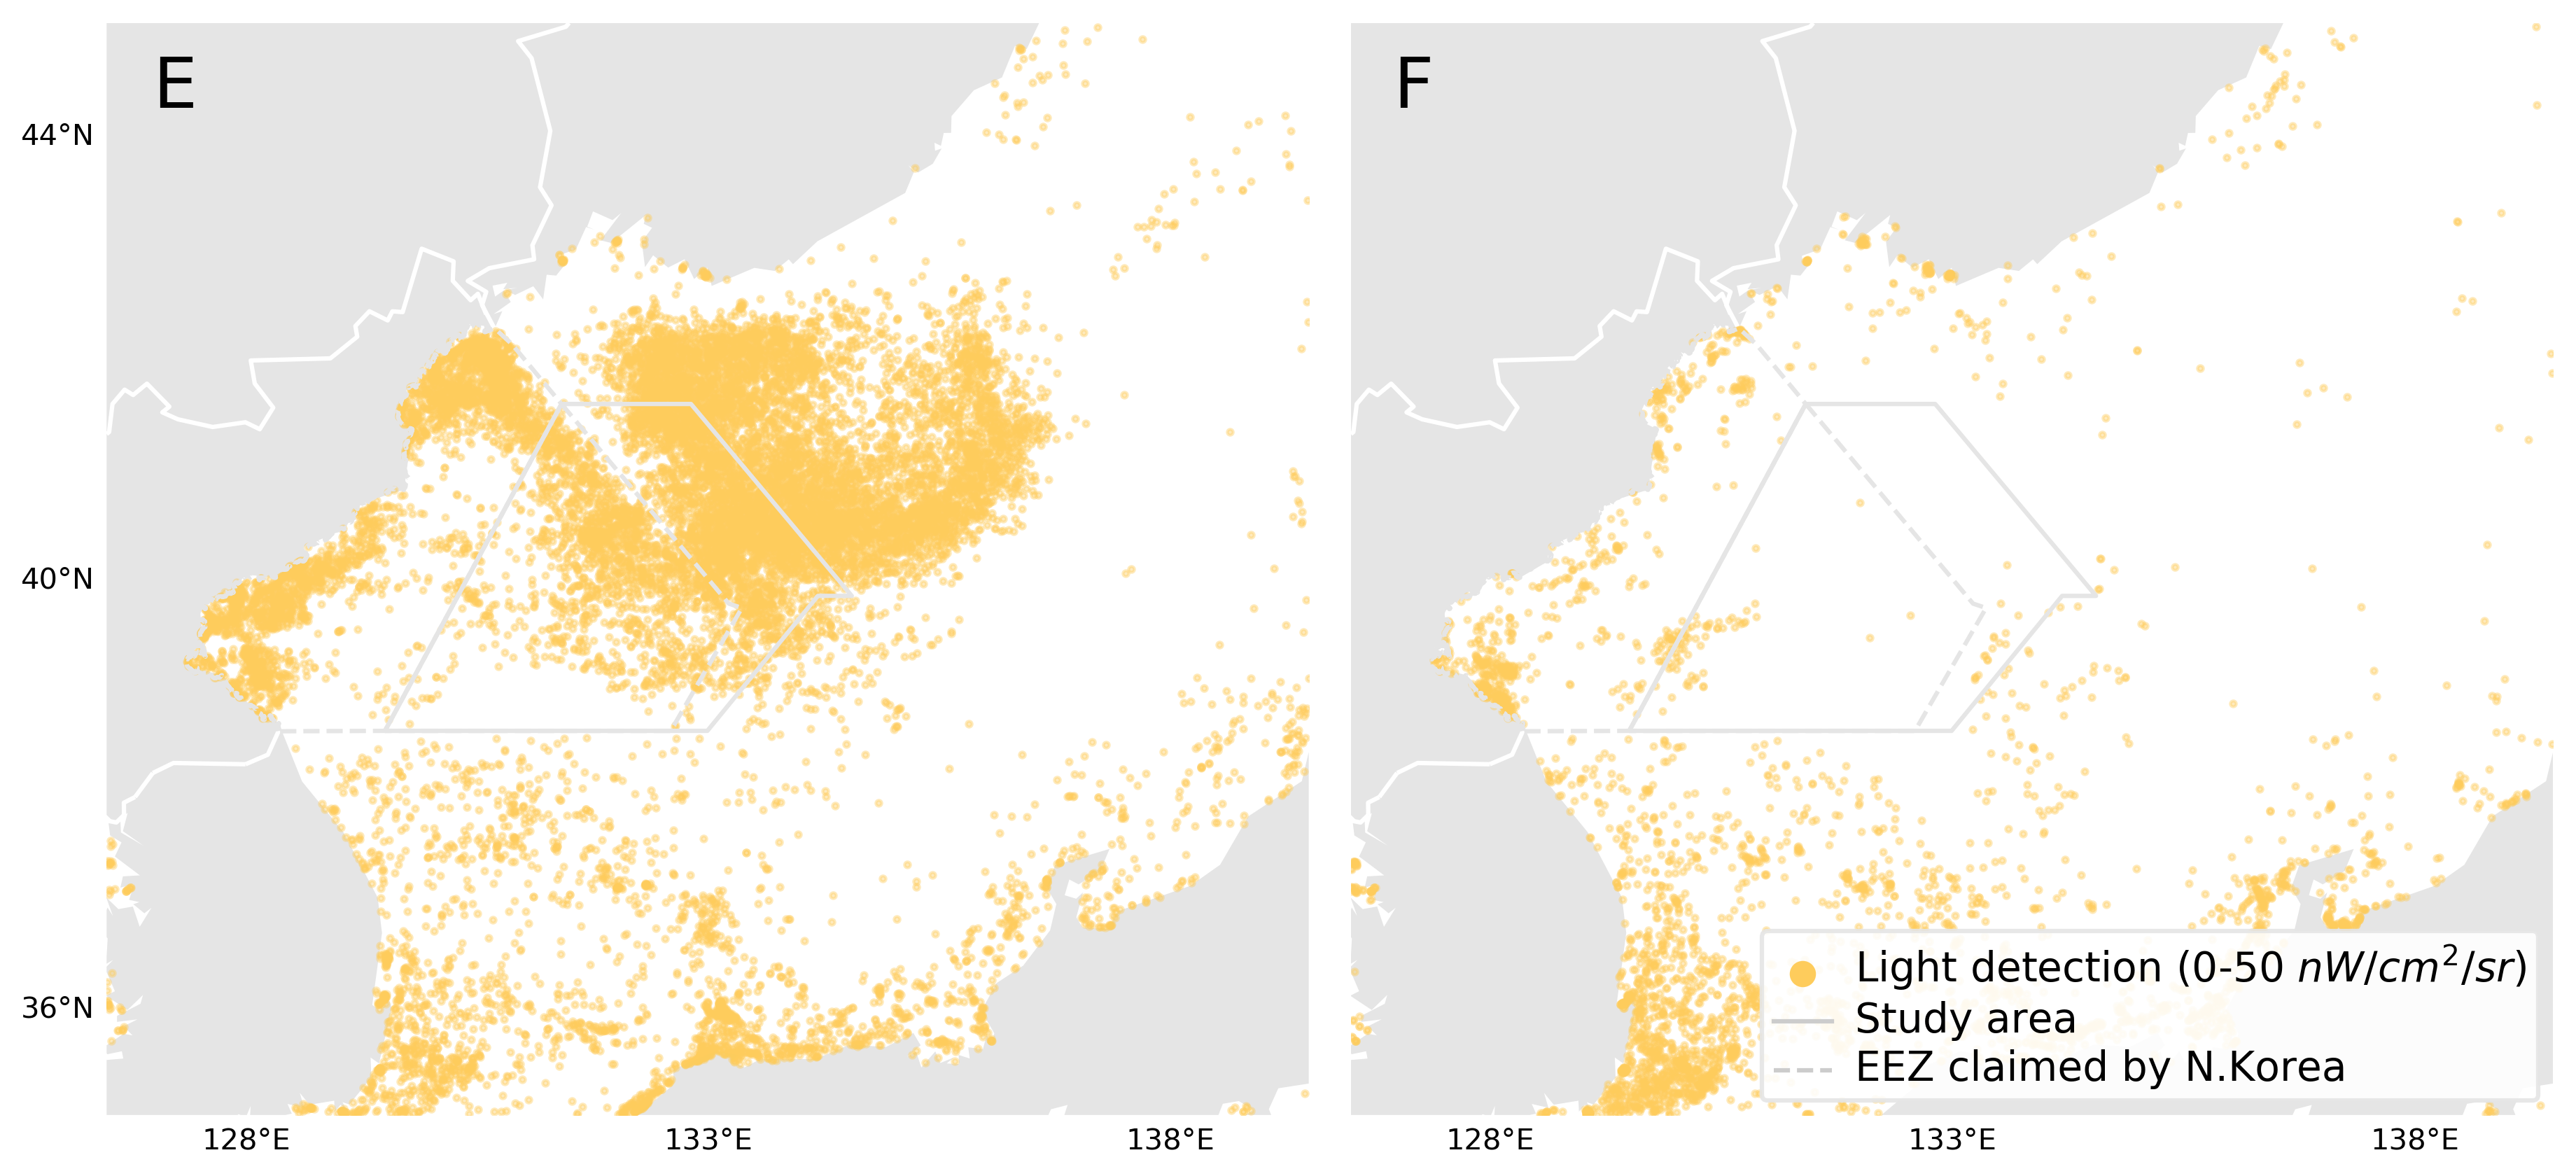

In [37]:
compare_viirs(all_detections_2017_halfmonthly_max, 'low', 'E', 'F')

## Number of detections of likely Chinese vessels and N.Korean vessels
This script shows the counts of Chinese and N. Korean vessels in each half-month period in the previous years (2017-2018 for Chinese vessels, and 2015-2018 for N. Korean vessels). These numbers will be used to create Fig. 4 of the paper.

In [38]:
q = """
SELECT *
FROM `paper_dark_fishing_fleets_in_north_korea.viirs_study_area_2017`
"""
study_area_2017 = pd.read_gbq(q, project_id='global-fishing-watch', dialect='standard')

In [39]:
#
# Estimate the number of Chinese vessels by counting half-monthly maximum
# number that exceed the cutoff above (meaning no other vessels can reach
# this level of brightness in N.Korean waters), therefore all of these 
# vessels in the studay area are likely Chinese lighting vessels in 2017.
#
study_area_2017['date'] = study_area_2017['Date_Mscan']\
                            .apply(lambda x: x.strftime('%Y/%m/%d'))
startdate = datetime.datetime(2017, 1, 1)
enddate = datetime.datetime(2018, 1, 1)

chinese_2017_halfmonthly_max = []
daily_nums = []

#
# Loop through daily detections to filter VIIRS detection 
# for the period of interest and categorize detections by intensity
#
date = startdate
while date < enddate:
    datestr = "{:%Y/%m/%d}".format(date)
    study_area_2017_daily = study_area_2017[study_area_2017['date'] == datestr]
    #
    # Detections of likely Chinese vessels
    if len(study_area_2017_daily) > 0:
        num = len(study_area_2017_daily[study_area_2017_daily['Rad_DNB'] >= 500])
        daily_nums.append(num)
    else:
        daily_nums.append(0)

    date += datetime.timedelta(days=1)

#
# Get the half-monthly maximum count above the cutoff
window_length = [15, 16, 15, 13, 15, 16, 15, 15, 15, 16, 15, 15, 
                 15, 16, 15, 16, 15, 15, 15, 16, 15, 15, 15, 16]

daily_nums_iter = iter(daily_nums)
for winlen in window_length:
    max_count = max(next(daily_nums_iter) for _ in range(winlen))
    chinese_2017_halfmonthly_max.append(max_count)

In [40]:
q = """
SELECT *
FROM `paper_dark_fishing_fleets_in_north_korea.viirs_study_area_2018`
"""
study_area_2018 = pd.read_gbq(q, project_id='global-fishing-watch', dialect='standard')

In [41]:
#
# Estimate the number of Chinese vessels by counting half-monthly maximum
# number that exceed the cutoff above (meaning no other vessels can reach
# this level of brightness in N.Korean waters), therefore all of these 
# vessels in the studay area are likely Chinese lighting vessels in 2018.
#
study_area_2018['date'] = study_area_2018['Date_Mscan'].apply(lambda x: x.strftime('%Y/%m/%d'))
startdate = datetime.datetime(2018, 1, 1)
enddate = datetime.datetime(2019, 1, 1)

chinese_2018_halfmonthly_max = []
daily_nums = []

#
# Loop through daily detections to filter VIIRS detection 
# for the period of interest and categorize detections by intensity
#
date = startdate
while date < enddate:
    datestr = "{:%Y/%m/%d}".format(date)
    study_area_2018_daily = study_area_2018[study_area_2018['date'] == datestr]
    #
    # Detections of likely Chinese vessels
    if len(study_area_2018_daily) > 0:
        num = len(study_area_2018_daily[study_area_2018_daily['Rad_DNB'] >= 500])
        daily_nums.append(num)
    else:
        daily_nums.append(0)

    date += datetime.timedelta(days=1)
    
#
# Get the half-monthly maximum count above the cutoff
window_length = [15, 16, 15, 13, 15, 16, 15, 15, 15, 16, 15, 15, 
                 15, 16, 15, 16, 15, 15, 15, 16, 15, 15, 15, 16]

daily_nums_iter = iter(daily_nums)
for winlen in window_length:
    max_count = max(next(daily_nums_iter) for _ in range(winlen))
    chinese_2018_halfmonthly_max.append(max_count)

### Half-monthly maximum counts of Chinese vessels operating in N.Korea

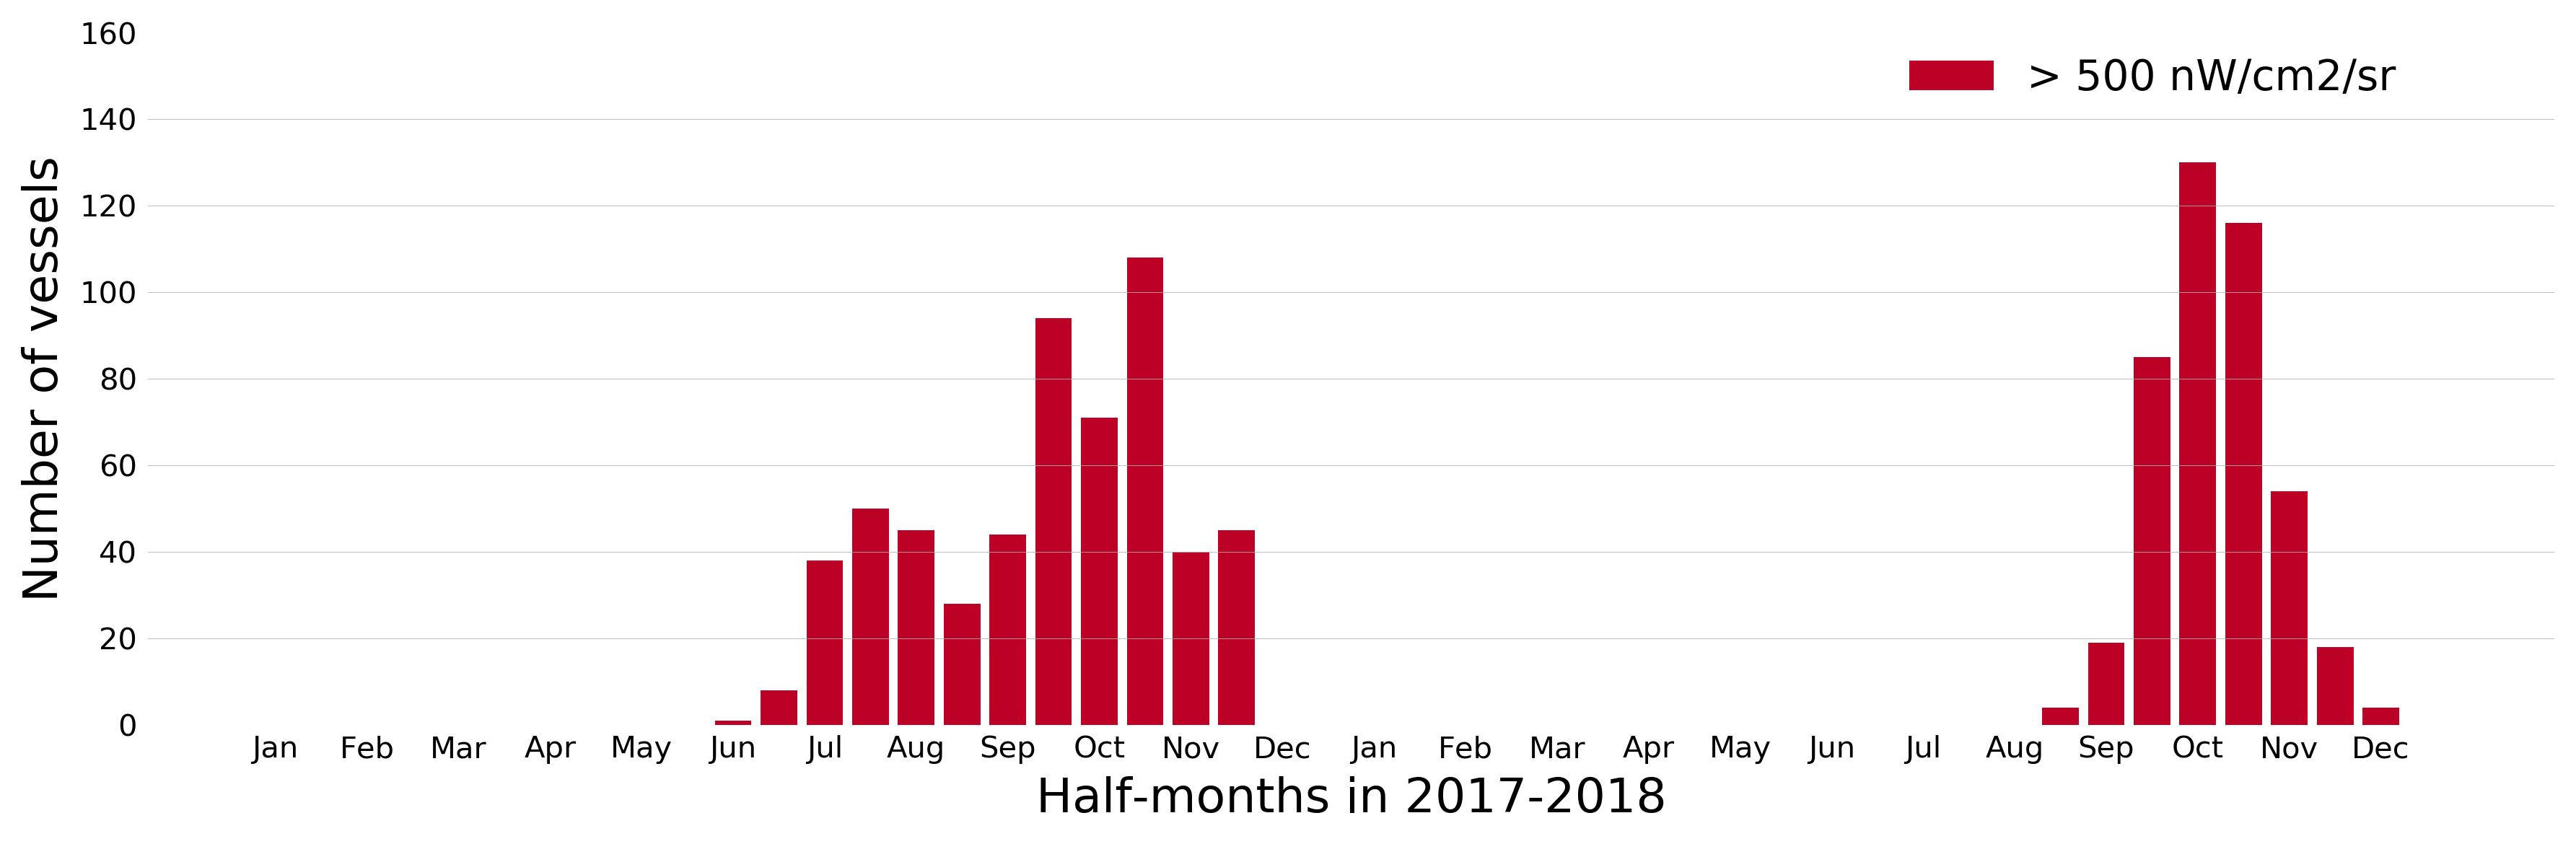

In [42]:
import matplotlib.ticker as ticker
fig = plt.figure(figsize=(12,4), dpi=300)
ax = fig.add_subplot(1, 1, 1)

c_range = ['#fecc5c', '#fd8d3c', '#bd0026'] 

#
# Plot bar chart
l = ax.bar(range(len(chinese_2017_halfmonthly_max) + len(chinese_2018_halfmonthly_max)), 
           chinese_2017_halfmonthly_max + chinese_2018_halfmonthly_max, 
             color=c_range[2]
            , label='> 500 nW/cm2/sr')

#
# Create legend
handles, labels = plt.gca().get_legend_handles_labels()
order = [0]
leg = ax.legend([handles[idx] for idx in order], 
                [labels[idx] for idx in order], 
                bbox_to_anchor=(0.95,0.85), frameon=False, 
                markerscale=2, fontsize=14, loc=4,ncol=4) 

#
# Some more configuration
for text in leg.get_texts():
    text.set_color("black")
for lh in leg.legendHandles: 
    lh.set_alpha(1)
for i, p in enumerate(leg.get_patches()):
    p.set_fc(c_range[2])

#
# Axes, labels
ax.set_facecolor((1,1,1))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.grid(lw=0.2, axis='y')
ax.tick_params(axis=u'both', which=u'both',length=0)

plt.ylabel('Number of vessels', fontsize=16) #fontproperties=rbt_reg, 
plt.ylim(0,160)
plt.xticks(range(len(chinese_2017_halfmonthly_max)*2),
           ['', ''] + ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
            'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'] * 2)

ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
plt.xlabel('Half-months in 2017-2018', fontsize=16) 
fig.tight_layout()
plt.show()

### Half-monthly maximum counts of N.Korean vessels in Russian waters

In [43]:
q = """
SELECT *
FROM `paper_dark_fishing_fleets_in_north_korea.viirs_rus_eez_wo_12nm_2015_2018`
"""
rus_eez_wo_12nm_2015_2018 = pd.read_gbq(q, project_id='global-fishing-watch', dialect='standard')

In [44]:
#
# Select the maximum daily count for each half-month period 
#
rus_eez_wo_12nm_2015_2018['date'] = \
    rus_eez_wo_12nm_2015_2018['Date_Mscan'].apply(lambda x: x.strftime('%Y/%m/%d'))
startdate = datetime.datetime(2015, 1, 1)
enddate = datetime.datetime(2019, 1, 1)

rus_eez_wo_12nm_2015_2018_halfmonthly_max = []
daily_nums = []

#
# Loop through daily detections to filter VIIRS detection 
# for the period of interest and categorize detections by intensity
#
date = startdate
while date < enddate:
    datestr = "{:%Y/%m/%d}".format(date)
    rus_eez_wo_12nm_2015_2018_daily = \
        rus_eez_wo_12nm_2015_2018[rus_eez_wo_12nm_2015_2018['date'] == datestr]
    #
    # Detections of likely Chinese vessels
    if len(rus_eez_wo_12nm_2015_2018_daily) > 0:
        num = len(rus_eez_wo_12nm_2015_2018_daily)
        daily_nums.append(num)
    else:
        daily_nums.append(0)

    date += datetime.timedelta(days=1)
    
#
# Get the half-monthly maximum count above the cutoff
window_length = [15, 16, 15, 13, 15, 16, 15, 15, 15, 16, 15, 15, 
                 15, 16, 15, 16, 15, 15, 15, 16, 15, 15, 15, 16,
                 15, 16, 15, 14, 15, 16, 15, 15, 15, 16, 15, 15, 
                 15, 16, 15, 16, 15, 15, 15, 16, 15, 15, 15, 16,
                 15, 16, 15, 13, 15, 16, 15, 15, 15, 16, 15, 15, 
                 15, 16, 15, 16, 15, 15, 15, 16, 15, 15, 15, 16,
                 15, 16, 15, 13, 15, 16, 15, 15, 15, 16, 15, 15, 
                 15, 16, 15, 16, 15, 15, 15, 16, 15, 15, 15, 16]

daily_nums_iter = iter(daily_nums)
for winlen in window_length:
    max_count = max(next(daily_nums_iter) for _ in range(winlen))
    rus_eez_wo_12nm_2015_2018_halfmonthly_max.append(max_count)

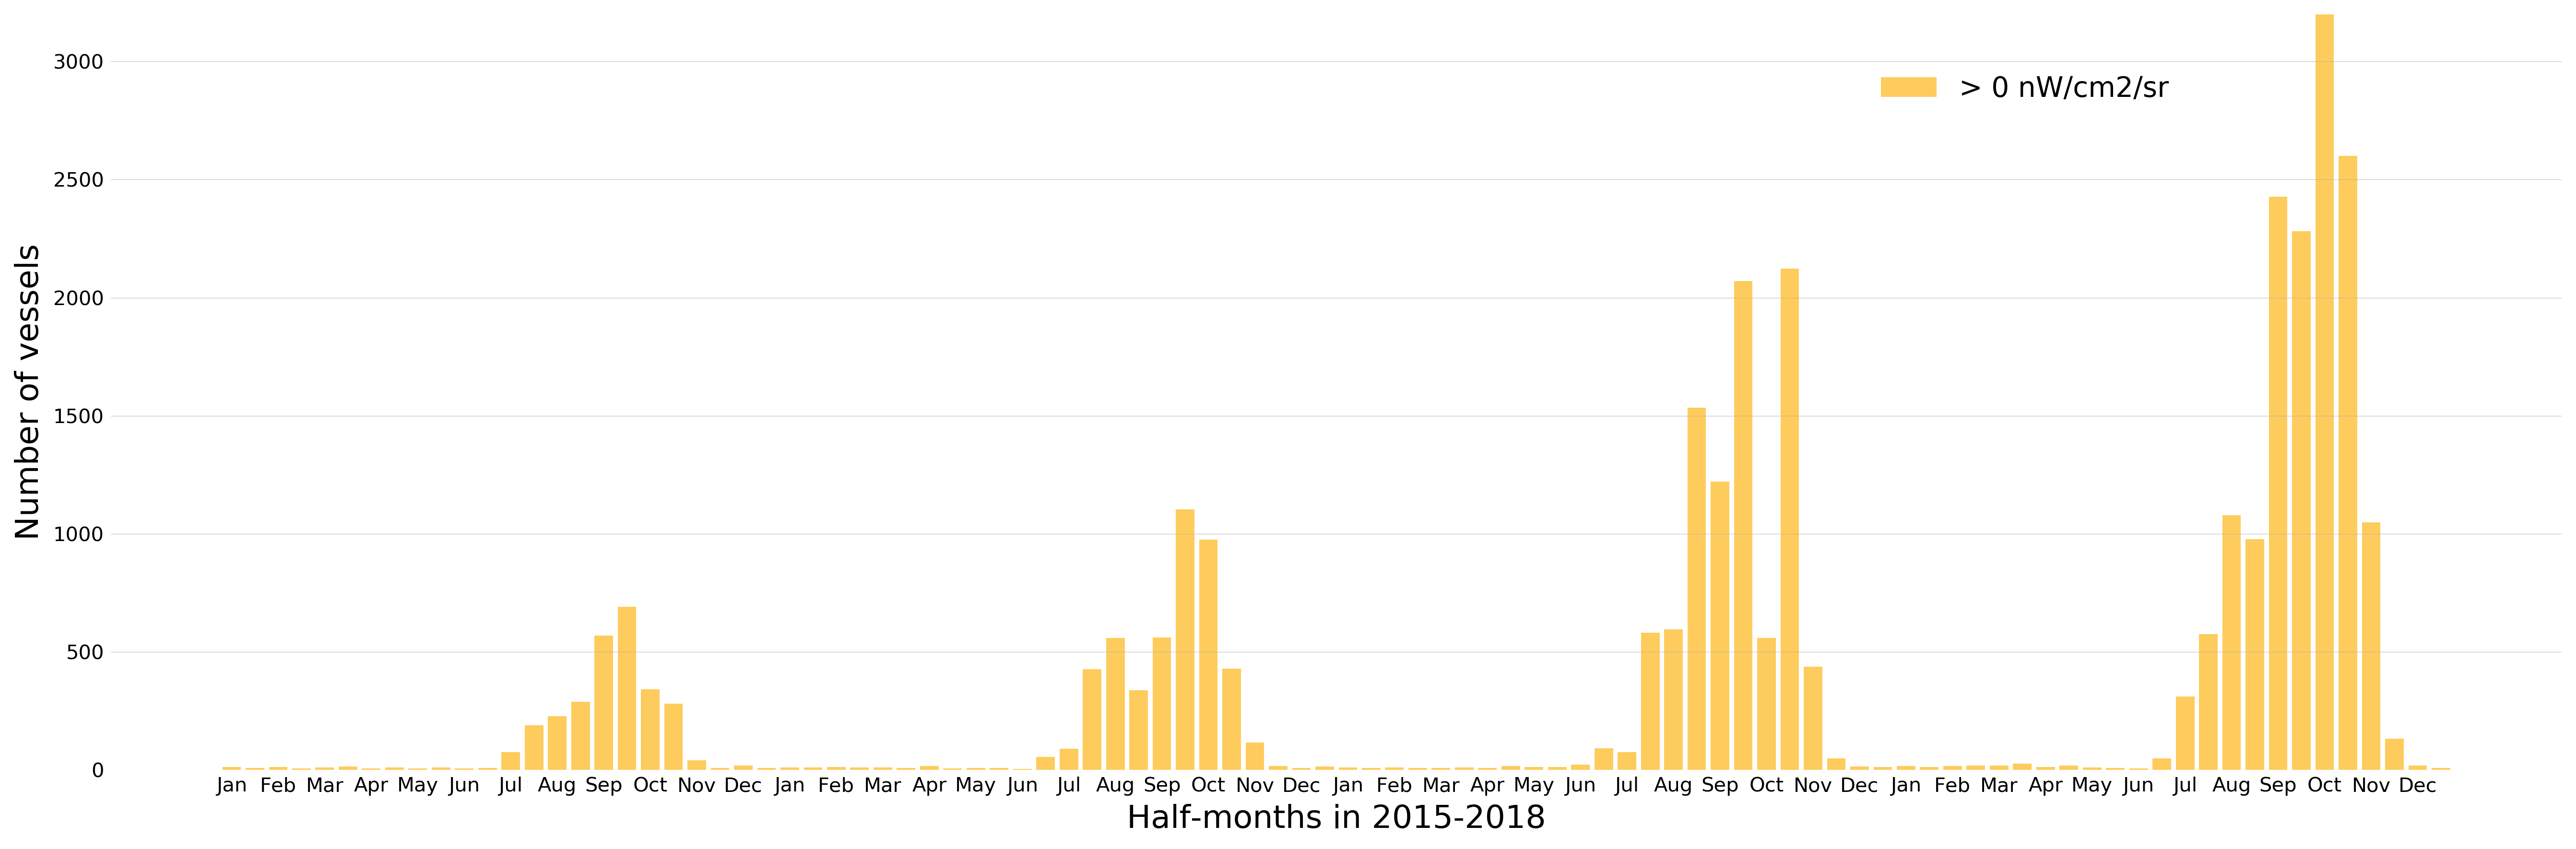

In [45]:
fig = plt.figure(figsize=(18,6), dpi=300)
ax = fig.add_subplot(1, 1, 1)

c_range = ['#fecc5c', '#fd8d3c', '#bd0026'] 

#
# Plot bar chart
l = ax.bar(range(len(rus_eez_wo_12nm_2015_2018_halfmonthly_max)), 
           rus_eez_wo_12nm_2015_2018_halfmonthly_max,
           color=c_range[0], 
           label='> 0 nW/cm2/sr')

#
# Create legend
handles, labels = plt.gca().get_legend_handles_labels()
order = [0]
leg = ax.legend([handles[idx] for idx in order], 
                [labels[idx] for idx in order], 
                bbox_to_anchor=(0.85,0.85), frameon=False, 
                markerscale=2, fontsize=14, loc=4,ncol=4) 

#
# Some more configuration
for text in leg.get_texts():
    text.set_color("black")
for lh in leg.legendHandles: 
    lh.set_alpha(1)
for i, p in enumerate(leg.get_patches()):
    p.set_fc(c_range[0])

#
# Axes, labels
ax.set_facecolor((1,1,1))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.grid(lw=0.2, axis='y')
ax.tick_params(axis=u'both', which=u'both',length=0)

plt.ylabel('Number of vessels', fontsize=16) 
plt.ylim(0,3200)
plt.xticks(range(len(rus_eez_wo_12nm_2015_2018_halfmonthly_max)),
           ['', '', ''] + ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
            'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'] * 4)

ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
plt.xlabel('Half-months in 2015-2018', fontsize=16) 

fig.tight_layout()
plt.show()

## All vessels detected in Russian territorial waters with light 
There are very few Russian vessels that can be detected using VIIRS throughout the year 2017, indicating that the number of Russian vessels are negligible in the VIIRS detections above (up to 3,000 a day).  

In [46]:
q = """
SELECT *
FROM `paper_dark_fishing_fleets_in_north_korea.viirs_rus_eez_12nm_2017`
"""
rus_eez_12nm_2017 = pd.read_gbq(q, project_id='global-fishing-watch', dialect='standard')

In [47]:
#
# Prepare the data for vessels detected on VIIRS sensor 
# in Russian territorial waters (within 20 nautical miles from the shore)
#
rus_eez_12nm_2017['date'] = rus_eez_12nm_2017['Date_Mscan']\
                            .apply(lambda x: x.strftime('%Y/%m/%d'))
startdate = datetime.datetime(2017, 1, 1)
enddate = datetime.datetime(2018, 1, 1)

rus_daily_nums = []

#
# Loop through daily detections to filter VIIRS detection 
# for the period of interest and categorize detections by intensity
#
date = startdate
while date < enddate:
    datestr = "{:%Y/%m/%d}".format(date)
    rus_eez_12nm_2017_daily = \
        rus_eez_12nm_2017[rus_eez_12nm_2017['date'] == datestr]
    #
    # Detections of likely Chinese vessels
    if len(rus_eez_12nm_2017_daily) > 0:
        num = len(rus_eez_12nm_2017_daily)
        rus_daily_nums.append(num)
    else:
        rus_daily_nums.append(0)

    date += datetime.timedelta(days=1)

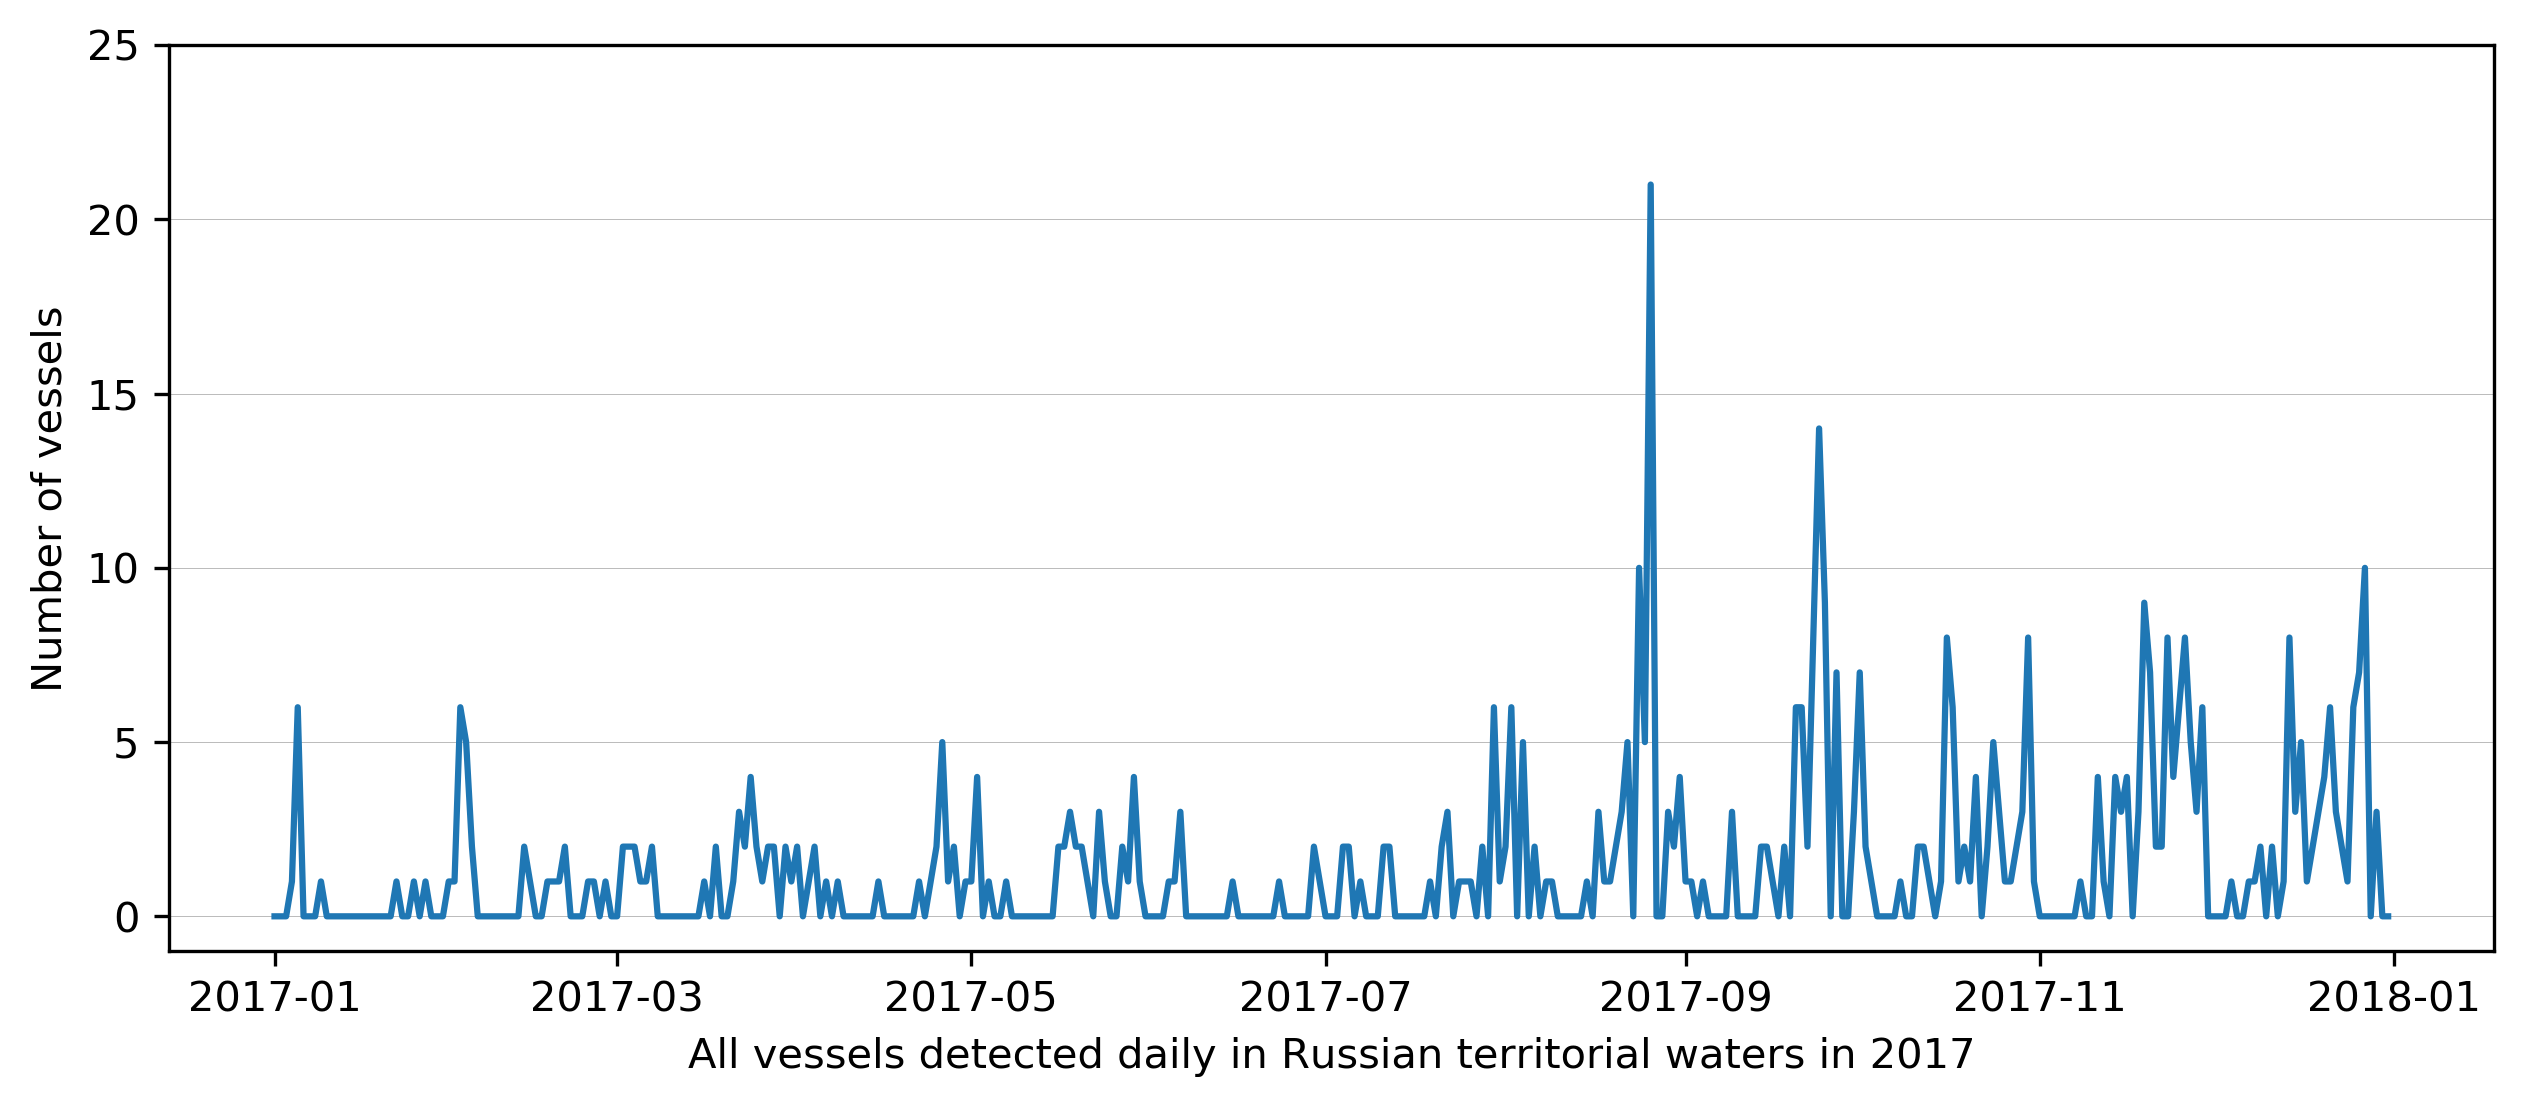

In [48]:
fig = plt.figure(figsize=(10,4), dpi=300)
ax = fig.add_subplot(1, 1, 1)

ax.plot(pd.date_range('20170101', '20171231'), rus_daily_nums) 
ax.set_facecolor('white')

ax.set_xlabel("All vessels detected daily in Russian territorial waters in 2017")
ax.set_ylabel("Number of vessels")
ax.grid(lw=0.2, axis='y')
plt.ylim(-1, 25)
plt.show()

## Determine the size of window for maximum daily detection with regard to daily cloud levels near Ulleung Islands in 2017

In [49]:
q = """
SELECT * 
FROM `paper_dark_fishing_fleets_in_north_korea.daily_cloud_near_ulleung_2017` 
ORDER BY day_of_year
"""
cloud = pd.read_gbq(q, project_id='global-fishing-watch', dialect='standard')

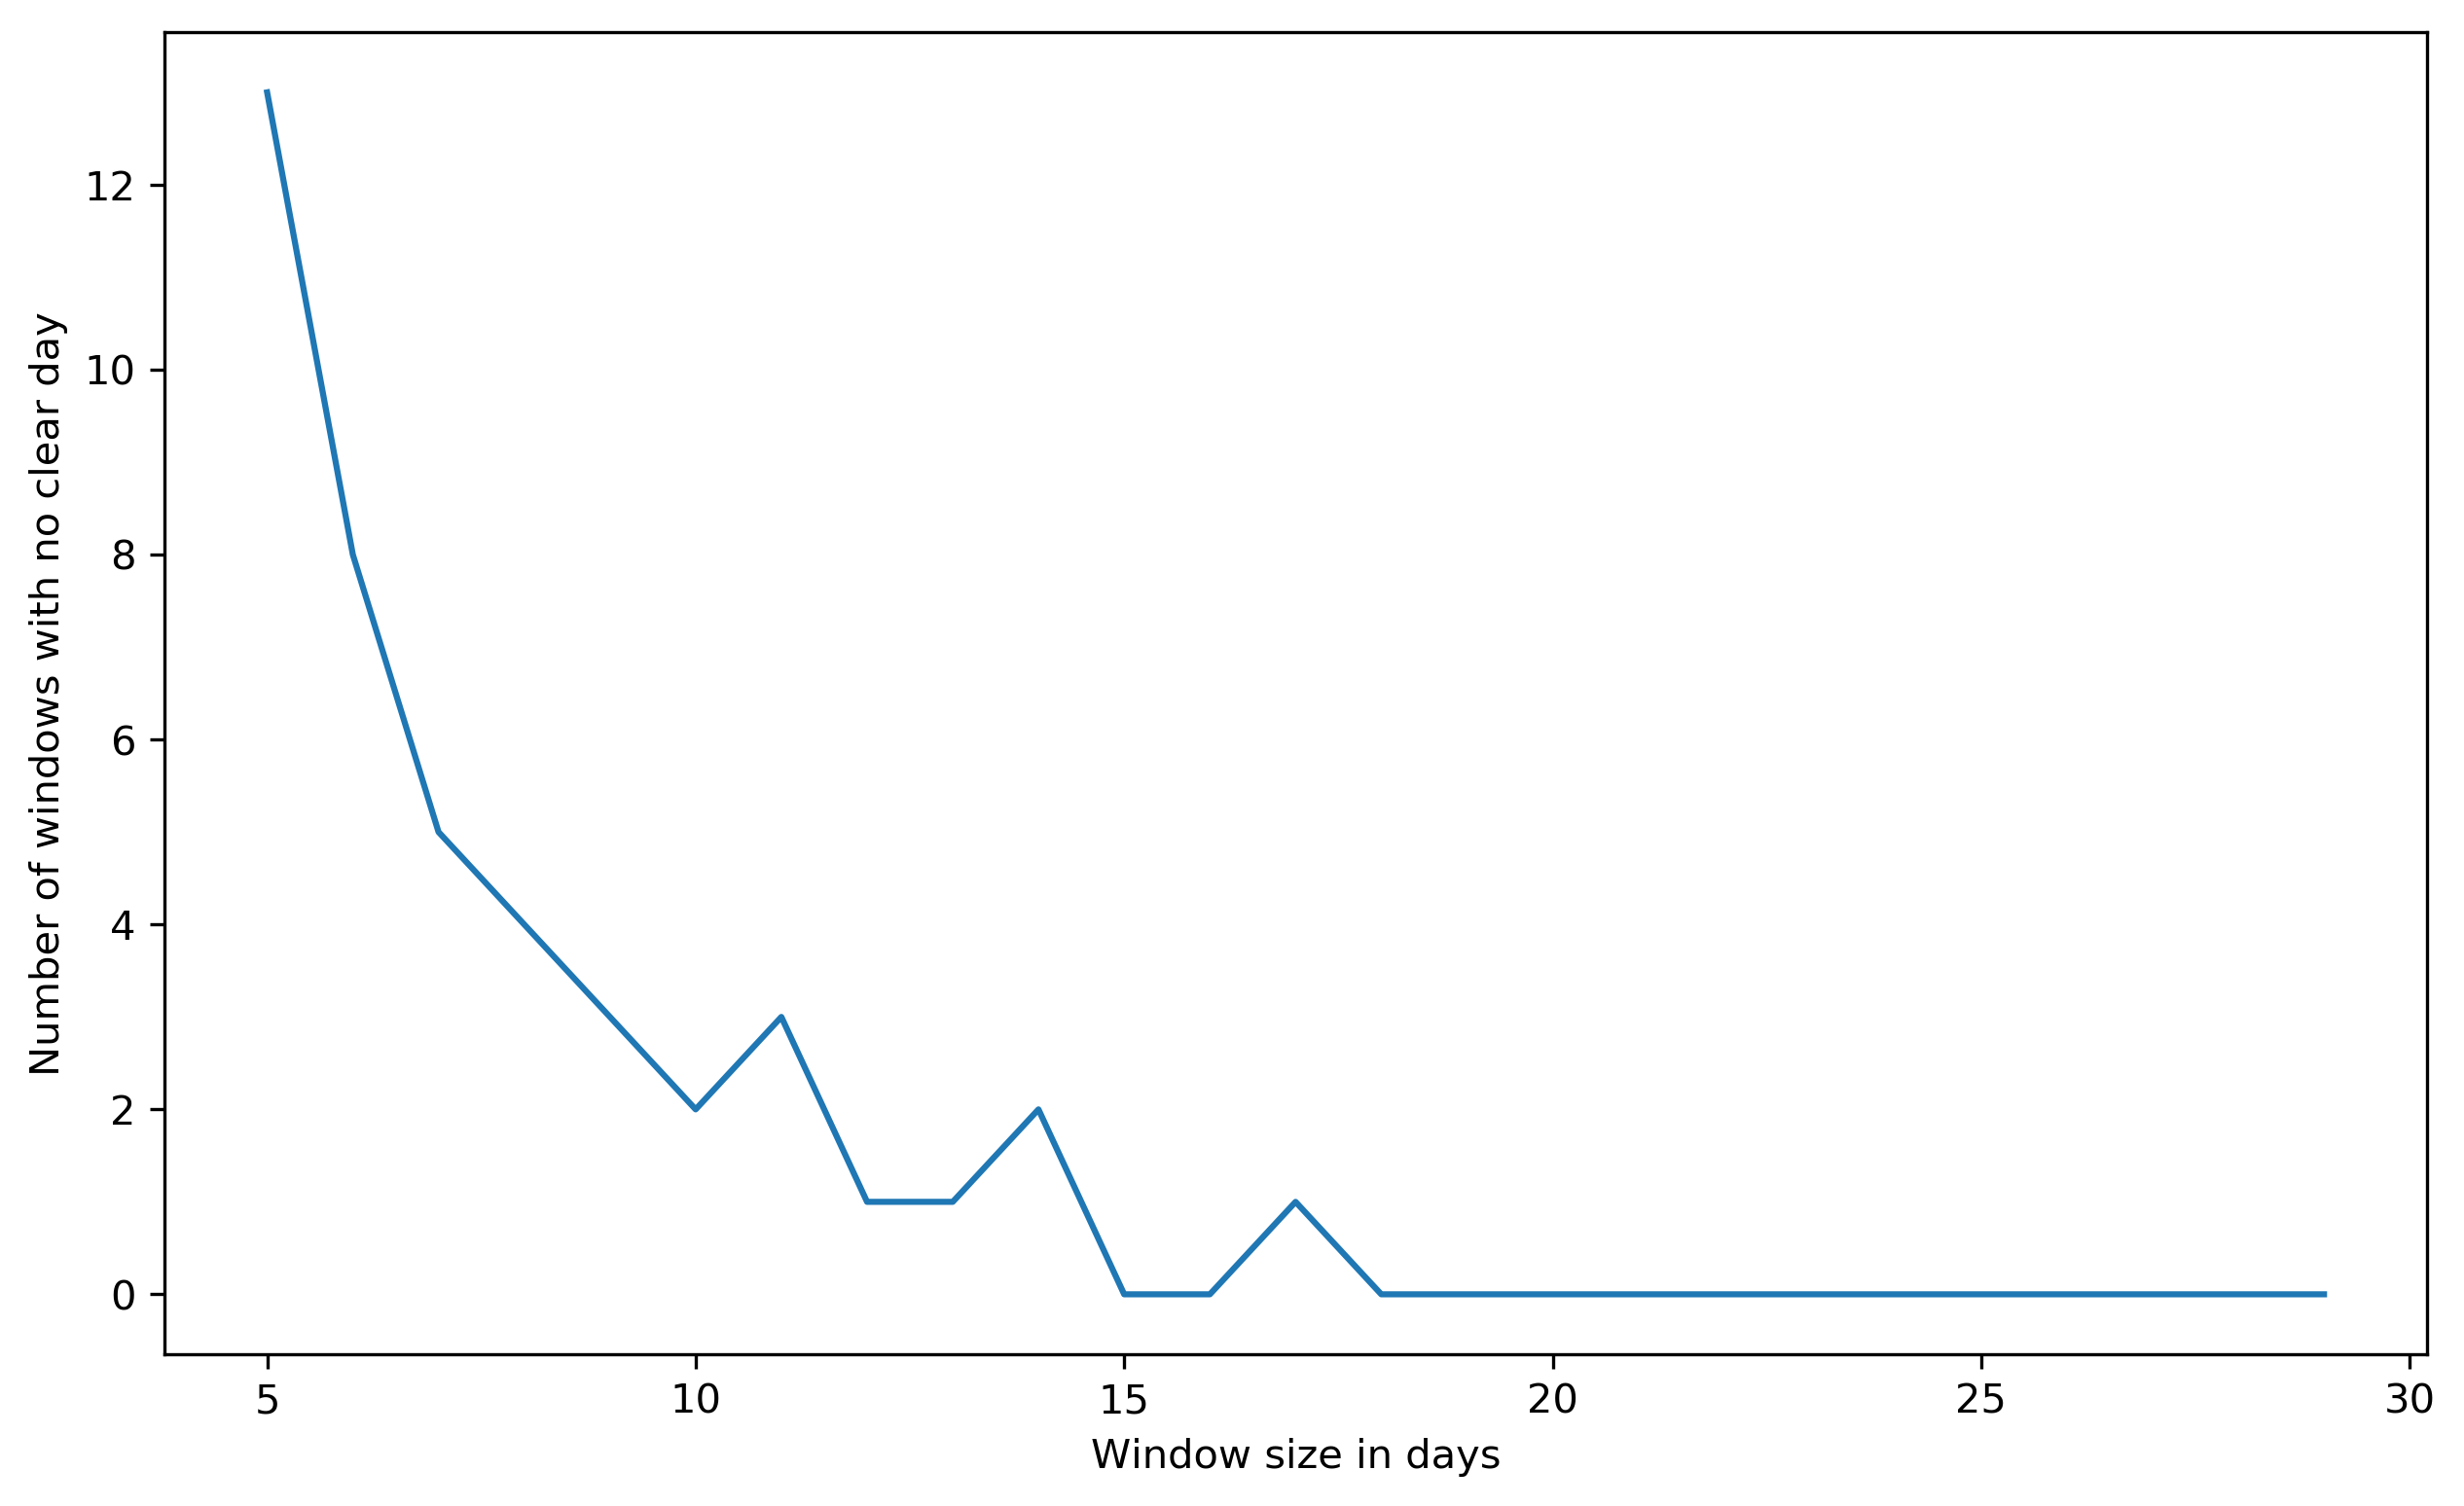

In [50]:
#
# Determine the minimum length of window in which that allows all windows 
# to have at least 1 clear day (cloud level <5) near Ulleung island
# 15 days (half-month) is the smallest window to meet such condition
#
year=2017
basedate = '20170515'

startdate = datetime.datetime.strptime(basedate, "%Y%m%d")
enddate = datetime.datetime.strptime(basedate, "%Y%m%d") + \
    datetime.timedelta(days=210)
fig = plt.figure(figsize=(10,6), facecolor='white', dpi=300)
cloudfree = []
result = []
for k in range(1,30,1):
    for i in range(int(210 / k)):
        temp = list(cloud['level'][133:345])[i * k : (i + 1) * k]
        n = len([c for c in temp if c < 5])
        cloudfree.append(n)
    result.append(len([a for a in cloudfree if a==0]))
    cloudfree = []

plt.plot(range(5,30,1),result[4:30])
plt.xlabel('Window size in days')
plt.ylabel('Number of windows with no clear day')
plt.show()

## Example query for creating VIIRS data sets for an area of interest out of the raw VIIRS dataset in BigQuery tables 
Below present only a couple of example queries that generate appropriate data sets for each area of interest. Other data sets, generated with the same method, are available under `global-fishing-watch` as Project ID - see below for the locations of the data sets. 

`paper_dark_fishing_fleets_in_north_korea.viirs_east_asia_2017`
`paper_dark_fishing_fleets_in_north_korea.viirs_study_area_2017`
`paper_dark_fishing_fleets_in_north_korea.viirs_study_area_2018`
`paper_dark_fishing_fleets_in_north_korea.viirs_rus_eez_12nm_2017`
`paper_dark_fishing_fleets_in_north_korea.viirs_rus_eez_north_2017`
`paper_dark_fishing_fleets_in_north_korea.viirs_rus_eez_wo_12nm_2015_2018`

In [65]:
q = """
# StandardSQL
WITH
  #
  # VIIRS raw data in the region for 2015-2018
  #
  data AS (
    SELECT *, DATE(Date_Mscan) AS date
    FROM `paper_dark_fishing_fleets_in_north_korea.viirs_raw_east_asia_2015_2018`
    WHERE Date_Mscan BETWEEN TIMESTAMP('2015-01-01') AND TIMESTAMP('2019-01-01')
  ),
  
  #
  # Add a Geography position for each detection point
  #
  positions AS (
    SELECT *, ST_GEOGPOINT(Lon_DNB, Lat_DNB) AS position
    FROM data
  ),
  
  #
  # Clip the detection area 
  #
  in_aoi AS (
    SELECT * EXCEPT (position)
    FROM positions
    #
    # Select the AOI that you want to analyze
    WHERE ST_CONTAINS(
      #
      # FOR THE AREA IN RUSSIAN EEZ WITHOUT TERRITORIAL WATERS
      (SELECT aoi FROM `paper_dark_fishing_fleets_in_north_korea.aoi_rus_eez_wo_12nm`), 
      position)
  ),
  
  #
  # Preparation work for grouping detections by satellite overpass
  # because often one day gets multiple overpasses (usually two
  # overpasses per day with a gap of 1.5 hours between the two) 
  # with different satellite zenith.
  #
  overpass_block AS (
    SELECT
      * EXCEPT (block_start),
      MAX(block_start) OVER (
        PARTITION BY date 
        ORDER BY Date_Mscan 
        ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS overpass_group
    FROM (
      SELECT
        *,
        IF(TIMESTAMP_DIFF(Date_Mscan, prev_mscan, HOUR) >= 1,
          Date_Mscan, NULL) AS block_start
      FROM (
        SELECT
          *,
          LAG(Date_Mscan, 1, TIMESTAMP("2000-01-01")) OVER (
            PARTITION BY date 
            ORDER BY Date_Mscan ) AS prev_mscan
        FROM in_aoi ) )
  ),
  
  #
  # Select the best detection group per day (the best overpass per day,
  # usually two overpasses a day with a gap of 1.5 hours )
  # based on the number of detections per overpass (which is affected
  # by weather condition at the moment of image acquisition), except
  # if the acquisition was made with a satellite zenith >=60 degree, then
  # take the detection group that was made by an overpass with the lowest
  # satellite zenith of the day
  #
  best_daily_overpass AS (
    SELECT * EXCEPT (prev_mscan, overpass_group)
    FROM (
      SELECT
        *,
        MIN(mean_satz) OVER (PARTITION BY date) AS daily_min_satz,
        MAX(mean_satz) OVER (PARTITION BY date) AS daily_max_satz,
        MAX(num_detections) OVER (PARTITION BY date) AS daily_max_detections
      FROM (
        SELECT
          *,
          AVG(SATZ_GDNBO) OVER (PARTITION BY overpass_group) AS mean_satz,
          COUNT(*) OVER (PARTITION BY overpass_group) AS num_detections
        FROM overpass_block ) )
    #
    # If one of the overpasses was taken with an average zenith >=60 degrees,
    # then take the other detection group with the lowest zenith, othewise
    # take the group that has the higher number of detections.
    # And remove the remaining detections made with a zenith > 60 degrees.
    WHERE 
      ((daily_max_satz >= 60 AND mean_satz = daily_min_satz) 
      OR (daily_max_satz < 60 AND num_detections = daily_max_detections))
      AND SATZ_GDNBO < 60
  )
  
SELECT *
FROM best_daily_overpass
"""
# rus_eez_wo_12nm_2015_2018 = pd.read_gbq(q, project_id='global-fishing-watch', dialect='standard')

In [66]:
q = """
# StandardSQL
WITH
  #
  # VIIRS raw data in the region for 2017
  #
  data AS (
    SELECT *, DATE(Date_Mscan) AS date
    FROM `paper_dark_fishing_fleets_in_north_korea.viirs_raw_east_asia_2015_2018`
    WHERE Date_Mscan BETWEEN TIMESTAMP('2017-01-01') AND TIMESTAMP('2018-01-01')
  ),
  
  #
  # Add a Geography position for each detection point
  #
  positions AS (
    SELECT *, ST_GEOGPOINT(Lon_DNB, Lat_DNB) AS position
    FROM data
  ),
  
  #
  # Clip the detection area 
  #
  in_aoi AS (
    SELECT * EXCEPT (position)
    FROM positions
    #
    # Select the AOI that you want to analyze
    WHERE ST_CONTAINS(
      #
      # FOR THE STUDY AREA
      (SELECT aoi FROM `paper_dark_fishing_fleets_in_north_korea.aoi_study_area`), 
      position)
  ),
  
  #
  # Preparation work for grouping detections by satellite overpass
  # because often one day gets multiple overpasses (usually two
  # overpasses per day with a gap of 1.5 hours between the two) 
  # with different satellite zenith.
  #
  overpass_block AS (
    SELECT
      * EXCEPT (block_start),
      MAX(block_start) OVER (
        PARTITION BY date 
        ORDER BY Date_Mscan 
        ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS overpass_group
    FROM (
      SELECT
        *,
        IF(TIMESTAMP_DIFF(Date_Mscan, prev_mscan, HOUR) >= 1,
          Date_Mscan, NULL) AS block_start
      FROM (
        SELECT
          *,
          LAG(Date_Mscan, 1, TIMESTAMP("2000-01-01")) OVER (
            PARTITION BY date 
            ORDER BY Date_Mscan ) AS prev_mscan
        FROM in_aoi ) )
  ),
  
  #
  # Select the best detection group per day (the best overpass per day,
  # usually two overpasses a day with a gap of 1.5 hours )
  # based on the number of detections per overpass (which is affected
  # by weather condition at the moment of image acquisition), except
  # if the acquisition was made with a satellite zenith >=60 degree, then
  # take the detection group that was made by an overpass with the lowest
  # satellite zenith of the day
  #
  best_daily_overpass AS (
    SELECT * EXCEPT (prev_mscan, overpass_group)
    FROM (
      SELECT
        *,
        MIN(mean_satz) OVER (PARTITION BY date) AS daily_min_satz,
        MAX(mean_satz) OVER (PARTITION BY date) AS daily_max_satz,
        MAX(num_detections) OVER (PARTITION BY date) AS daily_max_detections
      FROM (
        SELECT
          *,
          AVG(SATZ_GDNBO) OVER (PARTITION BY overpass_group) AS mean_satz,
          COUNT(*) OVER (PARTITION BY overpass_group) AS num_detections
        FROM overpass_block ) )
    #
    # If one of the overpasses was taken with an average zenith >=60 degrees,
    # then take the other detection group with the lowest zenith, othewise
    # take the group that has the higher number of detections.
    # And remove the remaining detections made with a zenith > 60 degrees.
    WHERE 
      ((daily_max_satz >= 60 AND mean_satz = daily_min_satz) 
      OR (daily_max_satz < 60 AND num_detections = daily_max_detections))
      AND SATZ_GDNBO < 60
  )
  
SELECT *
FROM best_daily_overpass
"""
# study_area_2017 = pd.read_gbq(q, project_id='global-fishing-watch', dialect='standard')

# Extra codes

In [90]:
# Improved codes for the code block above for Fig.S18

def fernando_faster(df, radiances, start_date, end_date):
    rad_values = df.rad.values
    i_sorted = np.argsort(rad_values)
    rad_sorted = rad_values[i_sorted]
    date_sorted = (df.date - start_date).dt.days.values[i_sorted]
    k_mins = np.searchsorted(rad_sorted, radiances)
    return [np.bincount(date_sorted[k_min:]).max() for k_min in k_mins]

%timeit fernando_faster(df, radiances, startdate, enddate)

The slowest run took 6.31 times longer than the fastest. This could mean that an intermediate result is being cached.
100 loops, best of 3: 2.31 ms per loop


In [91]:
# Another *even faster* solution was found, 
# which is even harder to read.

def avoid_extra_work(df, radiances, start_date, end_date):
    rad_values = df.rad.values
    rad_ndxs = np.argsort(rad_values)
    rad_values = df.rad.values[rad_ndxs]
    date_ints = df.date.values.astype('datetime64[D]').astype(int)
    offsets = (date_ints - date_ints[0])[rad_ndxs]
    rad_locs = np.searchsorted(rad_values, radiances)
    bincounts = np.zeros_like(offsets)
    last_loc = len(date_ints)
    results = []
    max_val = 0
    for loc in rad_locs[::-1]:
        if loc != last_loc:
            for o in offsets[loc:last_loc]:
                bc = bincounts[o] = bincounts[o] + 1
                if bc > max_val:
                    max_val = bc
            last_loc = loc
        results.append(max_val)
    return results[::-1]

%timeit avoid_extra_work(df, radiances, startdate, enddate)


1000 loops, best of 3: 1.23 ms per loop
